In [13]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [14]:
in_dir = '../data/two_years_each/train_val_skip'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

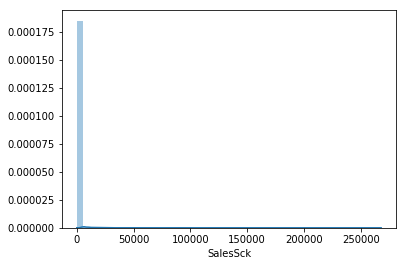

In [15]:
sns.distplot(df_train_Y['SalesSck'])
plt.plot()

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

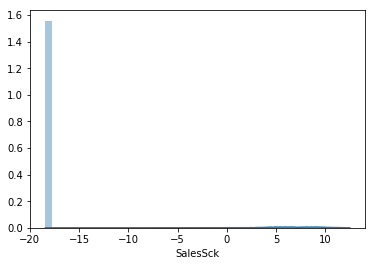

In [16]:
sns.distplot(np.log(df_train_Y['SalesSck'] + 0.00000001))
plt.plot()

In [17]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['SalesSck']:
    df_train_Y['SalesSck_log'] = df_train_Y['SalesSck'].apply(log)
    df_val_Y['SalesSck_log'] = df_val_Y['SalesSck'].apply(log)

### データ構造転換

In [18]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['SalesSck_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['SalesSck_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [19]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=100, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['SalesRyutsu'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 0.09852205604361887, 'colsample_bytree': 0.8, 'gamma': 0.03061328067750815, 'lambda': 1.1601712492309444e-05, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.10208172171692685, 'n_estimators': 743.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:16.8543	eval-rmse:16.9236                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:15.2784	eval-rmse:15.3403                                                                               

[2]	train-rmse:13.8704	eval-rmse:13.9233                                                                               

[3]	trai

[62]	train-rmse:3.97923	eval-rmse:3.89829                                                                              

[63]	train-rmse:3.97741	eval-rmse:3.89619                                                                              

[64]	train-rmse:3.97564	eval-rmse:3.89662                                                                              

[65]	train-rmse:3.97466	eval-rmse:3.89571                                                                              

[66]	train-rmse:3.97409	eval-rmse:3.89563                                                                              

[67]	train-rmse:3.97346	eval-rmse:3.89552                                                                              

[68]	train-rmse:3.9728	eval-rmse:3.89538                                                                               

[69]	train-rmse:3.97207	eval-rmse:3.8946                                                                               

[70]	train-rmse:3.97029	eval-rms

[31]	train-rmse:3.73526	eval-rmse:3.99318                                                                              

[32]	train-rmse:3.72788	eval-rmse:4.01148                                                                              

[33]	train-rmse:3.71825	eval-rmse:4.01078                                                                              

[34]	train-rmse:3.71285	eval-rmse:4.00738                                                                              

[35]	train-rmse:3.70721	eval-rmse:4.00326                                                                              

[36]	train-rmse:3.69708	eval-rmse:4.00809                                                                              

[37]	train-rmse:3.69325	eval-rmse:4.00772                                                                              

[38]	train-rmse:3.68458	eval-rmse:4.01235                                                                              

Stopping. Best iteration:       

[15]	train-rmse:2.98569	eval-rmse:4.16249                                                                              

[16]	train-rmse:2.9427	eval-rmse:4.19679                                                                               

[17]	train-rmse:2.93315	eval-rmse:4.19076                                                                              

[18]	train-rmse:2.90692	eval-rmse:4.1948                                                                               

[19]	train-rmse:2.87768	eval-rmse:4.20018                                                                              

[20]	train-rmse:2.83282	eval-rmse:4.21468                                                                              

[21]	train-rmse:2.79226	eval-rmse:4.22089                                                                              

[22]	train-rmse:2.77946	eval-rmse:4.22351                                                                              

[23]	train-rmse:2.74594	eval-rms

[2]	train-rmse:8.66762	eval-rmse:8.74335                                                                               

[3]	train-rmse:7.01628	eval-rmse:7.10507                                                                               

[4]	train-rmse:5.88475	eval-rmse:5.97356                                                                               

[5]	train-rmse:5.12761	eval-rmse:5.21512                                                                               

[6]	train-rmse:4.64069	eval-rmse:4.72455                                                                               

[7]	train-rmse:4.33796	eval-rmse:4.41846                                                                               

[8]	train-rmse:4.15544	eval-rmse:4.23191                                                                               

[9]	train-rmse:4.04002	eval-rmse:4.11581                                                                               

[10]	train-rmse:3.96848	eval-rms

[26]	train-rmse:3.36746	eval-rmse:4.12023                                                                              

[27]	train-rmse:3.35501	eval-rmse:4.12308                                                                              

[28]	train-rmse:3.33341	eval-rmse:4.14242                                                                              

[29]	train-rmse:3.32018	eval-rmse:4.13662                                                                              

[30]	train-rmse:3.30949	eval-rmse:4.13996                                                                              

[31]	train-rmse:3.30116	eval-rmse:4.14128                                                                              

[32]	train-rmse:3.28098	eval-rmse:4.14726                                                                              

[33]	train-rmse:3.27062	eval-rmse:4.15245                                                                              

[34]	train-rmse:3.25586	eval-rms

[6]	train-rmse:9.43517	eval-rmse:9.71411                                                                               

[7]	train-rmse:8.61897	eval-rmse:8.9343                                                                                

[8]	train-rmse:7.89669	eval-rmse:8.24355                                                                               

[9]	train-rmse:7.25277	eval-rmse:7.63727                                                                               

[10]	train-rmse:6.68419	eval-rmse:7.11425                                                                              

[11]	train-rmse:6.18303	eval-rmse:6.6829                                                                               

[12]	train-rmse:5.74194	eval-rmse:6.27611                                                                              

[13]	train-rmse:5.35568	eval-rmse:5.93513                                                                              

[14]	train-rmse:5.01852	eval-rms

[73]	train-rmse:2.64228	eval-rmse:4.04422                                                                              

[74]	train-rmse:2.64029	eval-rmse:4.04607                                                                              

[75]	train-rmse:2.63385	eval-rmse:4.04918                                                                              

Stopping. Best iteration:                                                                                              
[55]	train-rmse:2.77479	eval-rmse:4.00858


loss: 102067429.39579628                                                                                               
Training with params:                                                                                                  
{'alpha': 0.43822298230130463, 'colsample_bytree': 0.65, 'gamma': 0.0006579013547526185, 'lambda': 4.456937157073143, 'learning_rate': 0.125, 'max_depth': 7, 'min_child_weight': 0.133361520179093, 'n_estimators': 343.0, 'nthread': 4,

[57]	train-rmse:3.35229	eval-rmse:3.94535                                                                              

[58]	train-rmse:3.34463	eval-rmse:3.94685                                                                              

[59]	train-rmse:3.33892	eval-rmse:3.94947                                                                              

[60]	train-rmse:3.33104	eval-rmse:3.95027                                                                              

[61]	train-rmse:3.32416	eval-rmse:3.96081                                                                              

[62]	train-rmse:3.31827	eval-rmse:3.96045                                                                              

Stopping. Best iteration:                                                                                              
[42]	train-rmse:3.45777	eval-rmse:3.92028


loss: 102067438.52592836                                                                                      

[19]	train-rmse:3.77187	eval-rmse:4.08716                                                                              

[20]	train-rmse:3.75564	eval-rmse:4.08607                                                                              

[21]	train-rmse:3.73982	eval-rmse:4.08795                                                                              

[22]	train-rmse:3.72884	eval-rmse:4.09199                                                                              

[23]	train-rmse:3.72379	eval-rmse:4.09682                                                                              

[24]	train-rmse:3.71732	eval-rmse:4.08844                                                                              

[25]	train-rmse:3.71155	eval-rmse:4.08561                                                                              

[26]	train-rmse:3.70034	eval-rmse:4.09402                                                                              

[27]	train-rmse:3.6897	eval-rmse

[13]	train-rmse:3.08727	eval-rmse:4.18548                                                                              

[14]	train-rmse:3.03946	eval-rmse:4.16283                                                                              

[15]	train-rmse:3.00907	eval-rmse:4.15003                                                                              

[16]	train-rmse:2.988	eval-rmse:4.12779                                                                                

[17]	train-rmse:2.97444	eval-rmse:4.12808                                                                              

[18]	train-rmse:2.96258	eval-rmse:4.12489                                                                              

[19]	train-rmse:2.93611	eval-rmse:4.1254                                                                               

[20]	train-rmse:2.93315	eval-rmse:4.12461                                                                              

[21]	train-rmse:2.91713	eval-rms

[29]	train-rmse:3.79399	eval-rmse:4.02631                                                                              

[30]	train-rmse:3.78446	eval-rmse:4.03073                                                                              

[31]	train-rmse:3.7723	eval-rmse:4.04019                                                                               

[32]	train-rmse:3.76565	eval-rmse:4.03153                                                                              

[33]	train-rmse:3.75614	eval-rmse:4.03613                                                                              

Stopping. Best iteration:                                                                                              
[13]	train-rmse:3.92136	eval-rmse:3.96503


loss: 102067398.39668827                                                                                               
Training with params:                                                                                          

[54]	train-rmse:3.01172	eval-rmse:3.98652                                                                              

[55]	train-rmse:3.00173	eval-rmse:3.99056                                                                              

[56]	train-rmse:2.99281	eval-rmse:3.99099                                                                              

[57]	train-rmse:2.98285	eval-rmse:3.99419                                                                              

[58]	train-rmse:2.97855	eval-rmse:3.99536                                                                              

[59]	train-rmse:2.96707	eval-rmse:3.9975                                                                               

[60]	train-rmse:2.96045	eval-rmse:4.0045                                                                               

[61]	train-rmse:2.95136	eval-rmse:4.00692                                                                              

Stopping. Best iteration:       

[52]	train-rmse:5.80642	eval-rmse:6.33615                                                                              

[53]	train-rmse:5.70489	eval-rmse:6.24768                                                                              

[54]	train-rmse:5.60516	eval-rmse:6.16022                                                                              

[55]	train-rmse:5.50921	eval-rmse:6.07482                                                                              

[56]	train-rmse:5.41567	eval-rmse:5.99369                                                                              

[57]	train-rmse:5.32576	eval-rmse:5.91396                                                                              

[58]	train-rmse:5.23691	eval-rmse:5.83757                                                                              

[59]	train-rmse:5.15333	eval-rmse:5.76318                                                                              

[60]	train-rmse:5.07075	eval-rms

[13]	train-rmse:3.71673	eval-rmse:4.05409                                                                              

[14]	train-rmse:3.69732	eval-rmse:4.05008                                                                              

[15]	train-rmse:3.69099	eval-rmse:4.04755                                                                              

[16]	train-rmse:3.67144	eval-rmse:4.0518                                                                               

[17]	train-rmse:3.65078	eval-rmse:4.05237                                                                              

[18]	train-rmse:3.64001	eval-rmse:4.05005                                                                              

[19]	train-rmse:3.62394	eval-rmse:4.06873                                                                              

[20]	train-rmse:3.60709	eval-rmse:4.05422                                                                              

[21]	train-rmse:3.59367	eval-rms

[8]	train-rmse:3.74488	eval-rmse:4.16408                                                                               

[9]	train-rmse:3.7247	eval-rmse:4.1726                                                                                 

[10]	train-rmse:3.70704	eval-rmse:4.1801                                                                               

[11]	train-rmse:3.69085	eval-rmse:4.19244                                                                              

[12]	train-rmse:3.66465	eval-rmse:4.19095                                                                              

[13]	train-rmse:3.65294	eval-rmse:4.19667                                                                              

[14]	train-rmse:3.63787	eval-rmse:4.20173                                                                              

[15]	train-rmse:3.62127	eval-rmse:4.242                                                                                

[16]	train-rmse:3.6091	eval-rmse

[40]	train-rmse:3.87902	eval-rmse:3.95701                                                                              

[41]	train-rmse:3.8732	eval-rmse:3.95791                                                                               

Stopping. Best iteration:                                                                                              
[21]	train-rmse:3.95292	eval-rmse:3.93562


loss: 102067436.387495                                                                                                 
Training with params:                                                                                                  
{'alpha': 2.5480179459410192e-05, 'colsample_bytree': 0.75, 'gamma': 3.1319432900595788e-06, 'lambda': 0.00318869454275537, 'learning_rate': 0.225, 'max_depth': 4, 'min_child_weight': 4.843483502498032, 'n_estimators': 200.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:14.6654	eval-rmse:14.7337                                            

[1]	train-rmse:7.24547	eval-rmse:7.29342                                                                               

[2]	train-rmse:5.29471	eval-rmse:5.32044                                                                               

[3]	train-rmse:4.44866	eval-rmse:4.46763                                                                               

[4]	train-rmse:4.11155	eval-rmse:4.13601                                                                               

[5]	train-rmse:3.97672	eval-rmse:4.01045                                                                               

[6]	train-rmse:3.91974	eval-rmse:3.99782                                                                               

[7]	train-rmse:3.89972	eval-rmse:3.97753                                                                               

[8]	train-rmse:3.87741	eval-rmse:3.98384                                                                               

[9]	train-rmse:3.86277	eval-rmse

[33]	train-rmse:3.90824	eval-rmse:3.93801                                                                              

[34]	train-rmse:3.90203	eval-rmse:3.94067                                                                              

[35]	train-rmse:3.89874	eval-rmse:3.94104                                                                              

[36]	train-rmse:3.8936	eval-rmse:3.94769                                                                               

[37]	train-rmse:3.8896	eval-rmse:3.94729                                                                               

[38]	train-rmse:3.88755	eval-rmse:3.94978                                                                              

[39]	train-rmse:3.88405	eval-rmse:3.94692                                                                              

[40]	train-rmse:3.87825	eval-rmse:3.95124                                                                              

[41]	train-rmse:3.87367	eval-rms

[0]	train-rmse:18.1732	eval-rmse:18.2459                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:17.7442	eval-rmse:17.8154                                                                               

[2]	train-rmse:17.323	eval-rmse:17.3967                                                                                

[3]	train-rmse:16.9146	eval-rmse:16.9887                                                                               

[4]	train-rmse:16.5155	eval-rmse:16.5908                                                                               

[5]	train-rmse:16.1286	eval-rmse:16.2036                                                                               

[6]	train-rmse:15.7513	eval-rms

[65]	train-rmse:5.22683	eval-rmse:5.29365                                                                              

[66]	train-rmse:5.17009	eval-rmse:5.23651                                                                              

[67]	train-rmse:5.11519	eval-rmse:5.18035                                                                              

[68]	train-rmse:5.062	eval-rmse:5.12751                                                                                

[69]	train-rmse:5.01063	eval-rmse:5.07668                                                                              

[70]	train-rmse:4.96193	eval-rmse:5.0279                                                                               

[71]	train-rmse:4.91425	eval-rmse:4.98053                                                                              

[72]	train-rmse:4.86899	eval-rmse:4.9356                                                                               

[73]	train-rmse:4.82508	eval-rms

[26]	train-rmse:3.91042	eval-rmse:3.93741                                                                              

[27]	train-rmse:3.90396	eval-rmse:3.93804                                                                              

[28]	train-rmse:3.90096	eval-rmse:3.9354                                                                               

[29]	train-rmse:3.8985	eval-rmse:3.94025                                                                               

[30]	train-rmse:3.89329	eval-rmse:3.93734                                                                              

[31]	train-rmse:3.8898	eval-rmse:3.92836                                                                               

[32]	train-rmse:3.88569	eval-rmse:3.93114                                                                              

[33]	train-rmse:3.88239	eval-rmse:3.93216                                                                              

[34]	train-rmse:3.87773	eval-rms

[29]	train-rmse:3.78135	eval-rmse:3.94258                                                                              

[30]	train-rmse:3.77763	eval-rmse:3.94578                                                                              

[31]	train-rmse:3.7737	eval-rmse:3.94479                                                                               

[32]	train-rmse:3.76776	eval-rmse:3.94022                                                                              

[33]	train-rmse:3.76384	eval-rmse:3.94147                                                                              

[34]	train-rmse:3.75321	eval-rmse:3.93935                                                                              

[35]	train-rmse:3.74568	eval-rmse:3.94072                                                                              

[36]	train-rmse:3.74109	eval-rmse:3.94086                                                                              

[37]	train-rmse:3.73822	eval-rms

[3]	train-rmse:6.37226	eval-rmse:6.48633                                                                               

[4]	train-rmse:5.33059	eval-rmse:5.46475                                                                               

[5]	train-rmse:4.67514	eval-rmse:4.81997                                                                               

[6]	train-rmse:4.2764	eval-rmse:4.43203                                                                                

[7]	train-rmse:4.04413	eval-rmse:4.21067                                                                               

[8]	train-rmse:3.90499	eval-rmse:4.09467                                                                               

[9]	train-rmse:3.82105	eval-rmse:4.0136                                                                                

[10]	train-rmse:3.77072	eval-rmse:3.98499                                                                              

[11]	train-rmse:3.73616	eval-rms

[27]	train-rmse:5.96064	eval-rmse:5.92209                                                                              

[28]	train-rmse:5.80357	eval-rmse:5.76141                                                                              

[29]	train-rmse:5.65706	eval-rmse:5.61071                                                                              

[30]	train-rmse:5.52239	eval-rmse:5.47186                                                                              

[31]	train-rmse:5.3983	eval-rmse:5.34204                                                                               

[32]	train-rmse:5.28211	eval-rmse:5.22421                                                                              

[33]	train-rmse:5.17604	eval-rmse:5.11336                                                                              

[34]	train-rmse:5.0774	eval-rmse:5.01152                                                                               

[35]	train-rmse:4.98616	eval-rms

[94]	train-rmse:4.00246	eval-rmse:3.88741                                                                              

[95]	train-rmse:4.00155	eval-rmse:3.88698                                                                              

[96]	train-rmse:4.00094	eval-rmse:3.8866                                                                               

[97]	train-rmse:4.00055	eval-rmse:3.88638                                                                              

[98]	train-rmse:3.99966	eval-rmse:3.88673                                                                              

[99]	train-rmse:3.99918	eval-rmse:3.88594                                                                              

loss: 102067437.00647198                                                                                               
Training with params:                                                                                                  
{'alpha': 2.2958669546573912e-07, 

[16]	train-rmse:4.02992	eval-rmse:4.01365                                                                              

[17]	train-rmse:4.00749	eval-rmse:3.98516                                                                              

[18]	train-rmse:3.99131	eval-rmse:3.96428                                                                              

[19]	train-rmse:3.97694	eval-rmse:3.95091                                                                              

[20]	train-rmse:3.96491	eval-rmse:3.94195                                                                              

[21]	train-rmse:3.95613	eval-rmse:3.93277                                                                              

[22]	train-rmse:3.95089	eval-rmse:3.92912                                                                              

[23]	train-rmse:3.94453	eval-rmse:3.92684                                                                              

[24]	train-rmse:3.93777	eval-rms

[29]	train-rmse:4.28659	eval-rmse:4.35335                                                                              

[30]	train-rmse:4.22943	eval-rmse:4.29796                                                                              

[31]	train-rmse:4.17996	eval-rmse:4.24907                                                                              

[32]	train-rmse:4.1378	eval-rmse:4.20852                                                                               

[33]	train-rmse:4.09922	eval-rmse:4.17128                                                                              

[34]	train-rmse:4.06539	eval-rmse:4.13403                                                                              

[35]	train-rmse:4.03699	eval-rmse:4.10256                                                                              

[36]	train-rmse:4.01191	eval-rmse:4.07696                                                                              

[37]	train-rmse:3.98821	eval-rms

[3]	train-rmse:10.3307	eval-rmse:10.3855                                                                               

[4]	train-rmse:9.03975	eval-rmse:9.08788                                                                               

[5]	train-rmse:7.9747	eval-rmse:8.01867                                                                                

[6]	train-rmse:7.10706	eval-rmse:7.13877                                                                               

[7]	train-rmse:6.4035	eval-rmse:6.42256                                                                                

[8]	train-rmse:5.84178	eval-rmse:5.86074                                                                               

[9]	train-rmse:5.39619	eval-rmse:5.41216                                                                               

[10]	train-rmse:5.05166	eval-rmse:5.05412                                                                              

[11]	train-rmse:4.7839	eval-rmse

[7]	train-rmse:4.41765	eval-rmse:4.69798                                                                               

[8]	train-rmse:4.12885	eval-rmse:4.43987                                                                               

[9]	train-rmse:3.93935	eval-rmse:4.26588                                                                               

[10]	train-rmse:3.81948	eval-rmse:4.16529                                                                              

[11]	train-rmse:3.72916	eval-rmse:4.11306                                                                              

[12]	train-rmse:3.68071	eval-rmse:4.06543                                                                              

[13]	train-rmse:3.63906	eval-rmse:4.04113                                                                              

[14]	train-rmse:3.61853	eval-rmse:4.01643                                                                              

[15]	train-rmse:3.59471	eval-rms

[27]	train-rmse:4.00651	eval-rmse:3.91015                                                                              

[28]	train-rmse:4.00378	eval-rmse:3.90673                                                                              

[29]	train-rmse:4.00262	eval-rmse:3.90609                                                                              

[30]	train-rmse:4.00047	eval-rmse:3.90789                                                                              

[31]	train-rmse:3.99797	eval-rmse:3.9108                                                                               

[32]	train-rmse:3.9955	eval-rmse:3.90757                                                                               

[33]	train-rmse:3.99263	eval-rmse:3.90763                                                                              

[34]	train-rmse:3.98941	eval-rmse:3.90318                                                                              

[35]	train-rmse:3.9869	eval-rmse

[12]	train-rmse:3.88478	eval-rmse:3.98805                                                                              

[13]	train-rmse:3.87045	eval-rmse:3.99741                                                                              

[14]	train-rmse:3.86374	eval-rmse:3.99487                                                                              

[15]	train-rmse:3.8596	eval-rmse:3.99552                                                                               

[16]	train-rmse:3.85515	eval-rmse:4.00001                                                                              

[17]	train-rmse:3.84652	eval-rmse:4.00601                                                                              

[18]	train-rmse:3.83886	eval-rmse:3.9982                                                                               

[19]	train-rmse:3.83369	eval-rmse:4.00118                                                                              

[20]	train-rmse:3.82601	eval-rms

[40]	train-rmse:3.23545	eval-rmse:4.00168                                                                              

[41]	train-rmse:3.22709	eval-rmse:3.99824                                                                              

[42]	train-rmse:3.22301	eval-rmse:3.99572                                                                              

[43]	train-rmse:3.21402	eval-rmse:3.99524                                                                              

[44]	train-rmse:3.20969	eval-rmse:3.9937                                                                               

[45]	train-rmse:3.19984	eval-rmse:3.99214                                                                              

[46]	train-rmse:3.18634	eval-rmse:3.9887                                                                               

[47]	train-rmse:3.1794	eval-rmse:3.98873                                                                               

[48]	train-rmse:3.17184	eval-rms

[27]	train-rmse:2.95301	eval-rmse:4.11076                                                                              

[28]	train-rmse:2.91874	eval-rmse:4.11827                                                                              

[29]	train-rmse:2.91127	eval-rmse:4.12024                                                                              

[30]	train-rmse:2.89748	eval-rmse:4.12483                                                                              

[31]	train-rmse:2.87972	eval-rmse:4.12558                                                                              

[32]	train-rmse:2.86596	eval-rmse:4.13671                                                                              

[33]	train-rmse:2.84638	eval-rmse:4.13446                                                                              

[34]	train-rmse:2.83331	eval-rmse:4.1357                                                                               

[35]	train-rmse:2.8207	eval-rmse

[3]	train-rmse:11.3597	eval-rmse:11.4838                                                                               

[4]	train-rmse:10.1139	eval-rmse:10.2539                                                                               

[5]	train-rmse:9.03725	eval-rmse:9.20098                                                                               

[6]	train-rmse:8.11536	eval-rmse:8.30632                                                                               

[7]	train-rmse:7.32813	eval-rmse:7.52986                                                                               

[8]	train-rmse:6.6616	eval-rmse:6.88131                                                                                

[9]	train-rmse:6.09691	eval-rmse:6.3431                                                                                

[10]	train-rmse:5.62349	eval-rmse:5.89628                                                                              

[11]	train-rmse:5.22923	eval-rms

[0]	train-rmse:15.1023	eval-rmse:15.1657                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.3329	eval-rmse:12.3909                                                                               

[2]	train-rmse:10.1663	eval-rmse:10.2024                                                                               

[3]	train-rmse:8.49184	eval-rmse:8.5179                                                                                

[4]	train-rmse:7.21945	eval-rmse:7.22382                                                                               

[5]	train-rmse:6.26163	eval-rmse:6.25945                                                                               

[6]	train-rmse:5.56313	eval-rms

[3]	train-rmse:13.908	eval-rmse:13.9859                                                                                

[4]	train-rmse:12.9576	eval-rmse:13.0336                                                                               

[5]	train-rmse:12.0845	eval-rmse:12.1618                                                                               

[6]	train-rmse:11.2819	eval-rmse:11.3613                                                                               

[7]	train-rmse:10.5463	eval-rmse:10.6256                                                                               

[8]	train-rmse:9.87593	eval-rmse:9.95357                                                                               

[9]	train-rmse:9.2602	eval-rmse:9.33724                                                                                

[10]	train-rmse:8.69906	eval-rmse:8.77753                                                                              

[11]	train-rmse:8.18929	eval-rms

[70]	train-rmse:3.77316	eval-rmse:3.94142                                                                              

[71]	train-rmse:3.77112	eval-rmse:3.94204                                                                              

[72]	train-rmse:3.76899	eval-rmse:3.94184                                                                              

[73]	train-rmse:3.7666	eval-rmse:3.9413                                                                                

[74]	train-rmse:3.76498	eval-rmse:3.94056                                                                              

[75]	train-rmse:3.76089	eval-rmse:3.94128                                                                              

[76]	train-rmse:3.75926	eval-rmse:3.94217                                                                              

[77]	train-rmse:3.75689	eval-rmse:3.93881                                                                              

[78]	train-rmse:3.75518	eval-rms

Training with params:                                                                                                  
{'alpha': 2.474829797180415e-06, 'colsample_bytree': 0.8500000000000001, 'gamma': 3.1775562443343635e-05, 'lambda': 6.140719024419757e-05, 'learning_rate': 0.15000000000000002, 'max_depth': 8, 'min_child_weight': 7.252708269488457, 'n_estimators': 627.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.9575	eval-rmse:16.0632                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.715	eval-rmse:13.8413                                                                                

[2]	train-rmse:11.829	eval-rmse:11.9745                                          

[6]	train-rmse:4.33597	eval-rmse:4.22553                                                                               

[7]	train-rmse:4.19295	eval-rmse:4.06367                                                                               

[8]	train-rmse:4.11648	eval-rmse:3.9884                                                                                

[9]	train-rmse:4.07617	eval-rmse:3.94862                                                                               

[10]	train-rmse:4.05323	eval-rmse:3.92761                                                                              

[11]	train-rmse:4.04031	eval-rmse:3.91115                                                                              

[12]	train-rmse:4.03041	eval-rmse:3.90538                                                                              

[13]	train-rmse:4.02593	eval-rmse:3.90084                                                                              

[14]	train-rmse:4.02126	eval-rms

Stopping. Best iteration:                                                                                              
[9]	train-rmse:3.59993	eval-rmse:4.30206


loss: 11857526772271.94                                                                                                
Training with params:                                                                                                  
{'alpha': 6.749059597434958e-05, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.10378875246671083, 'lambda': 0.03170879943796036, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 0.8835549880273151, 'n_estimators': 502.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:15.1022	eval-rmse:15.1697                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                   

[6]	train-rmse:7.07492	eval-rmse:7.15498                                                                               

[7]	train-rmse:6.36599	eval-rmse:6.44033                                                                               

[8]	train-rmse:5.79741	eval-rmse:5.88008                                                                               

[9]	train-rmse:5.34554	eval-rmse:5.42929                                                                               

[10]	train-rmse:4.99328	eval-rmse:5.0671                                                                               

[11]	train-rmse:4.71736	eval-rmse:4.79329                                                                              

[12]	train-rmse:4.50784	eval-rmse:4.58403                                                                              

[13]	train-rmse:4.34589	eval-rmse:4.42586                                                                              

[14]	train-rmse:4.22138	eval-rms

[16]	train-rmse:3.74015	eval-rmse:4.00805                                                                              

[17]	train-rmse:3.73042	eval-rmse:4.00422                                                                              

[18]	train-rmse:3.72243	eval-rmse:3.99956                                                                              

[19]	train-rmse:3.71547	eval-rmse:3.99574                                                                              

[20]	train-rmse:3.70436	eval-rmse:4.00227                                                                              

[21]	train-rmse:3.69882	eval-rmse:3.99941                                                                              

[22]	train-rmse:3.68807	eval-rmse:3.99387                                                                              

[23]	train-rmse:3.68018	eval-rmse:3.98195                                                                              

[24]	train-rmse:3.66374	eval-rms

Stopping. Best iteration:                                                                                              
[10]	train-rmse:3.24909	eval-rmse:4.33095


loss: 2576987831149826.5                                                                                               
Training with params:                                                                                                  
{'alpha': 0.13044985335243248, 'colsample_bytree': 0.8500000000000001, 'gamma': 4.052167009247296e-05, 'lambda': 1.1337972746224895e-06, 'learning_rate': 0.07500000000000001, 'max_depth': 4, 'min_child_weight': 4.096299948425137, 'n_estimators': 373.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:17.2925	eval-rmse:17.3661                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improve

[59]	train-rmse:3.92791	eval-rmse:3.92376                                                                              

[60]	train-rmse:3.92568	eval-rmse:3.92489                                                                              

[61]	train-rmse:3.9242	eval-rmse:3.92384                                                                               

[62]	train-rmse:3.92097	eval-rmse:3.92035                                                                              

[63]	train-rmse:3.91941	eval-rmse:3.91649                                                                              

[64]	train-rmse:3.91742	eval-rmse:3.91597                                                                              

[65]	train-rmse:3.9157	eval-rmse:3.91575                                                                               

[66]	train-rmse:3.91278	eval-rmse:3.91581                                                                              

[67]	train-rmse:3.912	eval-rmse:

[20]	train-rmse:3.18609	eval-rmse:4.05525                                                                              

[21]	train-rmse:3.15585	eval-rmse:4.06486                                                                              

[22]	train-rmse:3.14907	eval-rmse:4.0729                                                                               

[23]	train-rmse:3.13265	eval-rmse:4.07125                                                                              

[24]	train-rmse:3.11723	eval-rmse:4.06331                                                                              

[25]	train-rmse:3.08831	eval-rmse:4.05889                                                                              

[26]	train-rmse:3.07901	eval-rmse:4.06783                                                                              

[27]	train-rmse:3.06537	eval-rmse:4.11389                                                                              

[28]	train-rmse:3.05543	eval-rms

[45]	train-rmse:3.82601	eval-rmse:3.9204                                                                               

[46]	train-rmse:3.82043	eval-rmse:3.92278                                                                              

[47]	train-rmse:3.81929	eval-rmse:3.92118                                                                              

[48]	train-rmse:3.81774	eval-rmse:3.9184                                                                               

[49]	train-rmse:3.81612	eval-rmse:3.91611                                                                              

[50]	train-rmse:3.81386	eval-rmse:3.91517                                                                              

[51]	train-rmse:3.80818	eval-rmse:3.9143                                                                               

[52]	train-rmse:3.80508	eval-rmse:3.91274                                                                              

[53]	train-rmse:3.80399	eval-rms

[31]	train-rmse:3.87911	eval-rmse:3.94429                                                                              

[32]	train-rmse:3.87425	eval-rmse:3.94888                                                                              

[33]	train-rmse:3.86795	eval-rmse:3.94943                                                                              

[34]	train-rmse:3.86344	eval-rmse:3.95114                                                                              

[35]	train-rmse:3.85897	eval-rmse:3.95614                                                                              

[36]	train-rmse:3.85334	eval-rmse:3.95913                                                                              

[37]	train-rmse:3.85011	eval-rmse:3.95676                                                                              

[38]	train-rmse:3.84652	eval-rmse:3.96382                                                                              

[39]	train-rmse:3.84265	eval-rms

[50]	train-rmse:3.81746	eval-rmse:4.21243                                                                              

[51]	train-rmse:3.78829	eval-rmse:4.18945                                                                              

[52]	train-rmse:3.76061	eval-rmse:4.16565                                                                              

[53]	train-rmse:3.73638	eval-rmse:4.14883                                                                              

[54]	train-rmse:3.71485	eval-rmse:4.13262                                                                              

[55]	train-rmse:3.69448	eval-rmse:4.1196                                                                               

[56]	train-rmse:3.67471	eval-rmse:4.10291                                                                              

[57]	train-rmse:3.65739	eval-rmse:4.08786                                                                              

[58]	train-rmse:3.63994	eval-rms

[11]	train-rmse:3.84932	eval-rmse:3.96102                                                                              

[12]	train-rmse:3.83749	eval-rmse:3.95958                                                                              

[13]	train-rmse:3.82977	eval-rmse:3.97464                                                                              

[14]	train-rmse:3.81756	eval-rmse:3.97837                                                                              

[15]	train-rmse:3.80618	eval-rmse:3.96807                                                                              

[16]	train-rmse:3.79826	eval-rmse:3.96543                                                                              

[17]	train-rmse:3.78038	eval-rmse:4.00024                                                                              

[18]	train-rmse:3.76177	eval-rmse:4.01258                                                                              

[19]	train-rmse:3.74829	eval-rms

[41]	train-rmse:3.64439	eval-rmse:3.91643                                                                              

[42]	train-rmse:3.64044	eval-rmse:3.91495                                                                              

[43]	train-rmse:3.63451	eval-rmse:3.91747                                                                              

[44]	train-rmse:3.63165	eval-rmse:3.9187                                                                               

[45]	train-rmse:3.62457	eval-rmse:3.91983                                                                              

[46]	train-rmse:3.61714	eval-rmse:3.92639                                                                              

[47]	train-rmse:3.61295	eval-rmse:3.9263                                                                               

[48]	train-rmse:3.60452	eval-rmse:3.92676                                                                              

[49]	train-rmse:3.59571	eval-rms

[37]	train-rmse:3.88274	eval-rmse:3.94935                                                                              

[38]	train-rmse:3.88051	eval-rmse:3.94909                                                                              

[39]	train-rmse:3.87714	eval-rmse:3.95059                                                                              

[40]	train-rmse:3.87389	eval-rmse:3.95936                                                                              

[41]	train-rmse:3.86984	eval-rmse:3.96308                                                                              

[42]	train-rmse:3.86579	eval-rmse:3.96471                                                                              

[43]	train-rmse:3.86324	eval-rmse:3.97026                                                                              

[44]	train-rmse:3.85846	eval-rmse:3.9703                                                                               

Stopping. Best iteration:       

[12]	train-rmse:3.40652	eval-rmse:4.1221                                                                               

[13]	train-rmse:3.37521	eval-rmse:4.1307                                                                               

[14]	train-rmse:3.35113	eval-rmse:4.12801                                                                              

[15]	train-rmse:3.30885	eval-rmse:4.12561                                                                              

[16]	train-rmse:3.29925	eval-rmse:4.12802                                                                              

[17]	train-rmse:3.27423	eval-rmse:4.13978                                                                              

[18]	train-rmse:3.23378	eval-rmse:4.15405                                                                              

[19]	train-rmse:3.20488	eval-rmse:4.15998                                                                              

[20]	train-rmse:3.19116	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.0006	eval-rmse:13.1123                                                                               

[2]	train-rmse:10.9476	eval-rmse:11.0798                                                                               

[3]	train-rmse:9.28074	eval-rmse:9.44534                                                                               

[4]	train-rmse:7.94337	eval-rmse:8.13479                                                                               

[5]	train-rmse:6.88062	eval-rmse:7.11315                                                                               

[6]	train-rmse:6.03671	eval-rmse:6.32194                                                                               

[7]	train-rmse:5.38112	eval-rms

[9]	train-rmse:4.06357	eval-rmse:3.99194                                                                               

[10]	train-rmse:4.02475	eval-rmse:3.94761                                                                              

[11]	train-rmse:3.99865	eval-rmse:3.92928                                                                              

[12]	train-rmse:3.97999	eval-rmse:3.92602                                                                              

[13]	train-rmse:3.96511	eval-rmse:3.92528                                                                              

[14]	train-rmse:3.9564	eval-rmse:3.92212                                                                               

[15]	train-rmse:3.9528	eval-rmse:3.91851                                                                               

[16]	train-rmse:3.9493	eval-rmse:3.91965                                                                               

[17]	train-rmse:3.94091	eval-rms

[32]	train-rmse:3.89062	eval-rmse:3.90503                                                                              

[33]	train-rmse:3.88652	eval-rmse:3.90964                                                                              

[34]	train-rmse:3.88337	eval-rmse:3.90537                                                                              

[35]	train-rmse:3.87847	eval-rmse:3.90931                                                                              

[36]	train-rmse:3.8708	eval-rmse:3.91448                                                                               

[37]	train-rmse:3.86802	eval-rmse:3.91531                                                                              

[38]	train-rmse:3.86598	eval-rmse:3.91595                                                                              

[39]	train-rmse:3.86046	eval-rmse:3.91294                                                                              

[40]	train-rmse:3.85372	eval-rms

[1]	train-rmse:6.85904	eval-rmse:6.87506                                                                               

[2]	train-rmse:5.06936	eval-rmse:5.05195                                                                               

[3]	train-rmse:4.37106	eval-rmse:4.33362                                                                               

[4]	train-rmse:4.12452	eval-rmse:4.06953                                                                               

[5]	train-rmse:4.03688	eval-rmse:3.98778                                                                               

[6]	train-rmse:3.9972	eval-rmse:3.97227                                                                                

[7]	train-rmse:3.9781	eval-rmse:3.97494                                                                                

[8]	train-rmse:3.97027	eval-rmse:3.97144                                                                               

[9]	train-rmse:3.96661	eval-rmse

[31]	train-rmse:3.92531	eval-rmse:3.89666                                                                              

[32]	train-rmse:3.92277	eval-rmse:3.89385                                                                              

[33]	train-rmse:3.92165	eval-rmse:3.89223                                                                              

[34]	train-rmse:3.91973	eval-rmse:3.89417                                                                              

[35]	train-rmse:3.91826	eval-rmse:3.89443                                                                              

[36]	train-rmse:3.91484	eval-rmse:3.89892                                                                              

[37]	train-rmse:3.91362	eval-rmse:3.89872                                                                              

[38]	train-rmse:3.91223	eval-rmse:3.9016                                                                               

[39]	train-rmse:3.90831	eval-rms

[37]	train-rmse:3.86671	eval-rmse:3.9012                                                                               

[38]	train-rmse:3.86069	eval-rmse:3.90512                                                                              

[39]	train-rmse:3.85877	eval-rmse:3.907                                                                                

[40]	train-rmse:3.85303	eval-rmse:3.90237                                                                              

[41]	train-rmse:3.84689	eval-rmse:3.90114                                                                              

[42]	train-rmse:3.84307	eval-rmse:3.90336                                                                              

[43]	train-rmse:3.83822	eval-rmse:3.90005                                                                              

[44]	train-rmse:3.83373	eval-rmse:3.92153                                                                              

[45]	train-rmse:3.83027	eval-rms

[4]	train-rmse:3.99902	eval-rmse:4.09929                                                                               

[5]	train-rmse:3.95957	eval-rmse:4.05226                                                                               

[6]	train-rmse:3.94669	eval-rmse:4.04211                                                                               

[7]	train-rmse:3.93579	eval-rmse:4.03595                                                                               

[8]	train-rmse:3.91824	eval-rmse:4.05162                                                                               

[9]	train-rmse:3.90207	eval-rmse:4.04236                                                                               

[10]	train-rmse:3.89825	eval-rmse:4.04768                                                                              

[11]	train-rmse:3.88098	eval-rmse:4.06825                                                                              

[12]	train-rmse:3.86463	eval-rms

[35]	train-rmse:3.99142	eval-rmse:3.91756                                                                              

[36]	train-rmse:3.98969	eval-rmse:3.92251                                                                              

[37]	train-rmse:3.98633	eval-rmse:3.91947                                                                              

[38]	train-rmse:3.98336	eval-rmse:3.92233                                                                              

[39]	train-rmse:3.98187	eval-rmse:3.92391                                                                              

[40]	train-rmse:3.97931	eval-rmse:3.92619                                                                              

[41]	train-rmse:3.97639	eval-rmse:3.92694                                                                              

[42]	train-rmse:3.97424	eval-rmse:3.92786                                                                              

[43]	train-rmse:3.97283	eval-rms

{'alpha': 3.565279852116873e-08, 'colsample_bytree': 0.8, 'gamma': 3.955353746652033e-06, 'lambda': 0.0004926166429882602, 'learning_rate': 0.225, 'max_depth': 4, 'min_child_weight': 1.683483736826474, 'n_estimators': 349.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:14.6658	eval-rmse:14.7415                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.66	eval-rmse:11.7261                                                                                 

[2]	train-rmse:9.39688	eval-rmse:9.44272                                                                               

[3]	train-rmse:7.72335	eval-rmse:7.74288                                                                               

[4]

[13]	train-rmse:3.69446	eval-rmse:4.16826                                                                              

[14]	train-rmse:3.67037	eval-rmse:4.17464                                                                              

[15]	train-rmse:3.66378	eval-rmse:4.18787                                                                              

[16]	train-rmse:3.65717	eval-rmse:4.20449                                                                              

[17]	train-rmse:3.64316	eval-rmse:4.2126                                                                               

[18]	train-rmse:3.62447	eval-rmse:4.23158                                                                              

[19]	train-rmse:3.6032	eval-rmse:4.24383                                                                               

[20]	train-rmse:3.59368	eval-rmse:4.24016                                                                              

[21]	train-rmse:3.57869	eval-rms

[44]	train-rmse:3.78696	eval-rmse:3.90585                                                                              

[45]	train-rmse:3.78198	eval-rmse:3.91378                                                                              

[46]	train-rmse:3.77507	eval-rmse:3.91889                                                                              

[47]	train-rmse:3.77373	eval-rmse:3.91976                                                                              

[48]	train-rmse:3.76762	eval-rmse:3.9253                                                                               

[49]	train-rmse:3.7645	eval-rmse:3.92225                                                                               

[50]	train-rmse:3.76012	eval-rmse:3.92523                                                                              

[51]	train-rmse:3.75462	eval-rmse:3.93066                                                                              

[52]	train-rmse:3.7513	eval-rmse

[40]	train-rmse:3.80005	eval-rmse:3.91108                                                                              

[41]	train-rmse:3.79415	eval-rmse:3.90596                                                                              

[42]	train-rmse:3.79155	eval-rmse:3.90565                                                                              

[43]	train-rmse:3.78856	eval-rmse:3.90794                                                                              

[44]	train-rmse:3.78696	eval-rmse:3.90585                                                                              

[45]	train-rmse:3.78198	eval-rmse:3.91378                                                                              

[46]	train-rmse:3.77507	eval-rmse:3.91889                                                                              

[47]	train-rmse:3.77373	eval-rmse:3.91976                                                                              

[48]	train-rmse:3.76762	eval-rms

[37]	train-rmse:3.84782	eval-rmse:3.94557                                                                              

[38]	train-rmse:3.84295	eval-rmse:3.94286                                                                              

[39]	train-rmse:3.83867	eval-rmse:3.93708                                                                              

[40]	train-rmse:3.83188	eval-rmse:3.93224                                                                              

[41]	train-rmse:3.82718	eval-rmse:3.92611                                                                              

[42]	train-rmse:3.82336	eval-rmse:3.9263                                                                               

[43]	train-rmse:3.81751	eval-rmse:3.92405                                                                              

[44]	train-rmse:3.81465	eval-rmse:3.92183                                                                              

[45]	train-rmse:3.80906	eval-rms

[30]	train-rmse:3.81949	eval-rmse:3.94934                                                                              

[31]	train-rmse:3.81577	eval-rmse:3.94838                                                                              

[32]	train-rmse:3.81124	eval-rmse:3.94962                                                                              

[33]	train-rmse:3.80616	eval-rmse:3.94675                                                                              

[34]	train-rmse:3.80298	eval-rmse:3.94333                                                                              

[35]	train-rmse:3.79916	eval-rmse:3.94883                                                                              

[36]	train-rmse:3.79296	eval-rmse:3.94992                                                                              

[37]	train-rmse:3.79038	eval-rmse:3.9537                                                                               

[38]	train-rmse:3.78566	eval-rms

[35]	train-rmse:3.75162	eval-rmse:3.95395                                                                              

[36]	train-rmse:3.74705	eval-rmse:3.96374                                                                              

[37]	train-rmse:3.74431	eval-rmse:3.96302                                                                              

[38]	train-rmse:3.73922	eval-rmse:3.96397                                                                              

[39]	train-rmse:3.73188	eval-rmse:3.96445                                                                              

[40]	train-rmse:3.72457	eval-rmse:3.96799                                                                              

[41]	train-rmse:3.71943	eval-rmse:3.96622                                                                              

[42]	train-rmse:3.71375	eval-rmse:3.96631                                                                              

[43]	train-rmse:3.71086	eval-rms

[48]	train-rmse:4.16938	eval-rmse:4.23901                                                                              

[49]	train-rmse:4.14145	eval-rmse:4.21078                                                                              

[50]	train-rmse:4.11518	eval-rmse:4.18557                                                                              

[51]	train-rmse:4.09053	eval-rmse:4.16236                                                                              

[52]	train-rmse:4.06849	eval-rmse:4.13923                                                                              

[53]	train-rmse:4.04957	eval-rmse:4.12069                                                                              

[54]	train-rmse:4.03154	eval-rmse:4.10263                                                                              

[55]	train-rmse:4.0151	eval-rmse:4.08679                                                                               

[56]	train-rmse:3.99888	eval-rms

[9]	train-rmse:14.6791	eval-rmse:14.7568                                                                               

[10]	train-rmse:14.3403	eval-rmse:14.4183                                                                              

[11]	train-rmse:14.0129	eval-rmse:14.0897                                                                              

[12]	train-rmse:13.6924	eval-rmse:13.7686                                                                              

[13]	train-rmse:13.3788	eval-rmse:13.4569                                                                              

[14]	train-rmse:13.0767	eval-rmse:13.1521                                                                              

[15]	train-rmse:12.781	eval-rmse:12.8565                                                                               

[16]	train-rmse:12.4942	eval-rmse:12.5694                                                                              

[17]	train-rmse:12.2156	eval-rms

[76]	train-rmse:4.70336	eval-rmse:4.78408                                                                              

[77]	train-rmse:4.66612	eval-rmse:4.74743                                                                              

[78]	train-rmse:4.63074	eval-rmse:4.71202                                                                              

[79]	train-rmse:4.59619	eval-rmse:4.67865                                                                              

[80]	train-rmse:4.56346	eval-rmse:4.64637                                                                              

[81]	train-rmse:4.53245	eval-rmse:4.61604                                                                              

[82]	train-rmse:4.50178	eval-rmse:4.58515                                                                              

[83]	train-rmse:4.47341	eval-rmse:4.5564                                                                               

[84]	train-rmse:4.44578	eval-rms

[37]	train-rmse:3.1976	eval-rmse:4.15995                                                                               

[38]	train-rmse:3.16724	eval-rmse:4.13675                                                                              

[39]	train-rmse:3.14233	eval-rmse:4.12119                                                                              

[40]	train-rmse:3.11568	eval-rmse:4.10388                                                                              

[41]	train-rmse:3.09383	eval-rmse:4.09014                                                                              

[42]	train-rmse:3.07703	eval-rmse:4.07455                                                                              

[43]	train-rmse:3.0574	eval-rmse:4.0678                                                                                

[44]	train-rmse:3.03928	eval-rmse:4.06389                                                                              

[45]	train-rmse:3.02424	eval-rms

{'alpha': 1.1560134502024894e-07, 'colsample_bytree': 0.7000000000000001, 'gamma': 1.7002673604516543e-06, 'lambda': 1.280991196348296e-06, 'learning_rate': 0.17500000000000002, 'max_depth': 8, 'min_child_weight': 0.6606828071424116, 'n_estimators': 854.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:15.5132	eval-rmse:15.62                                                                                 

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.9773	eval-rmse:13.1288                                                                               

[2]	train-rmse:10.9144	eval-rmse:11.0892                                                                               

[3]	train-rmse:9.24361	eval-rmse:9.46621                                      

[11]	train-rmse:6.50746	eval-rmse:6.57613                                                                              

[12]	train-rmse:6.1058	eval-rmse:6.16874                                                                               

[13]	train-rmse:5.75652	eval-rmse:5.81964                                                                              

[14]	train-rmse:5.45607	eval-rmse:5.52132                                                                              

[15]	train-rmse:5.19961	eval-rmse:5.26411                                                                              

[16]	train-rmse:4.98068	eval-rmse:5.04831                                                                              

[17]	train-rmse:4.79507	eval-rmse:4.8655                                                                               

[18]	train-rmse:4.63891	eval-rmse:4.70905                                                                              

[19]	train-rmse:4.50669	eval-rms

{'alpha': 0.007479741403975844, 'colsample_bytree': 0.7000000000000001, 'gamma': 7.563154136254432e-07, 'lambda': 0.10278308426468624, 'learning_rate': 0.125, 'max_depth': 7, 'min_child_weight': 5.12539026100926, 'n_estimators': 786.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:16.401	eval-rmse:16.4883                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:14.4782	eval-rmse:14.5798                                                                               

[2]	train-rmse:12.8075	eval-rmse:12.9172                                                                               

[3]	train-rmse:11.3625	eval-rmse:11.4834                                                                         

loss: 102067974.38727456                                                                                               
Training with params:                                                                                                  
{'alpha': 2.9759584183943783e-07, 'colsample_bytree': 0.75, 'gamma': 0.008765966615382374, 'lambda': 1.8319587951597024e-05, 'learning_rate': 0.25, 'max_depth': 3, 'min_child_weight': 0.5731616977630375, 'n_estimators': 689.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:14.2396	eval-rmse:14.2985                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.0326	eval-rmse:11.0693                                                                      

[8]	train-rmse:4.25503	eval-rmse:4.45605                                                                               

[9]	train-rmse:4.07857	eval-rmse:4.28884                                                                               

[10]	train-rmse:3.96403	eval-rmse:4.16758                                                                              

[11]	train-rmse:3.88233	eval-rmse:4.09846                                                                              

[12]	train-rmse:3.8303	eval-rmse:4.05617                                                                               

[13]	train-rmse:3.7924	eval-rmse:4.03944                                                                               

[14]	train-rmse:3.77495	eval-rmse:4.01701                                                                              

[15]	train-rmse:3.7643	eval-rmse:4.00367                                                                               

[16]	train-rmse:3.74127	eval-rms

[28]	train-rmse:3.76632	eval-rmse:3.98199                                                                              

[29]	train-rmse:3.76248	eval-rmse:3.9738                                                                               

[30]	train-rmse:3.75304	eval-rmse:3.98281                                                                              

[31]	train-rmse:3.75127	eval-rmse:3.98002                                                                              

[32]	train-rmse:3.74518	eval-rmse:3.97958                                                                              

[33]	train-rmse:3.73868	eval-rmse:3.98491                                                                              

[34]	train-rmse:3.72648	eval-rmse:3.98438                                                                              

[35]	train-rmse:3.71945	eval-rmse:3.98561                                                                              

[36]	train-rmse:3.70748	eval-rms

[5]	train-rmse:4.17633	eval-rmse:4.21641                                                                               

[6]	train-rmse:4.02199	eval-rmse:4.08065                                                                               

[7]	train-rmse:3.94548	eval-rmse:4.02274                                                                               

[8]	train-rmse:3.90845	eval-rmse:3.99905                                                                               

[9]	train-rmse:3.87967	eval-rmse:3.98581                                                                               

[10]	train-rmse:3.86985	eval-rmse:3.97392                                                                              

[11]	train-rmse:3.86185	eval-rmse:3.98654                                                                              

[12]	train-rmse:3.8528	eval-rmse:3.98016                                                                               

[13]	train-rmse:3.84624	eval-rms

[34]	train-rmse:2.89204	eval-rmse:4.38123                                                                              

Stopping. Best iteration:                                                                                              
[14]	train-rmse:3.3046	eval-rmse:4.21064


loss: 160672521.45127705                                                                                               
Training with params:                                                                                                  
{'alpha': 8.66463876407267e-05, 'colsample_bytree': 0.6000000000000001, 'gamma': 4.161590941458714e-05, 'lambda': 0.016324498514481412, 'learning_rate': 0.375, 'max_depth': 5, 'min_child_weight': 0.3520661627535504, 'n_estimators': 838.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:12.0705	eval-rmse:12.141                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will 

[19]	train-rmse:3.33783	eval-rmse:4.24342                                                                              

[20]	train-rmse:3.29243	eval-rmse:4.26694                                                                              

[21]	train-rmse:3.2796	eval-rmse:4.28196                                                                               

[22]	train-rmse:3.26629	eval-rmse:4.32368                                                                              

[23]	train-rmse:3.25621	eval-rmse:4.3309                                                                               

[24]	train-rmse:3.2525	eval-rmse:4.33298                                                                               

[25]	train-rmse:3.22719	eval-rmse:4.35007                                                                              

[26]	train-rmse:3.21456	eval-rmse:4.34749                                                                              

[27]	train-rmse:3.18148	eval-rms

[4]	train-rmse:5.33238	eval-rmse:5.469                                                                                 

[5]	train-rmse:4.67877	eval-rmse:4.82298                                                                               

[6]	train-rmse:4.28529	eval-rmse:4.44999                                                                               

[7]	train-rmse:4.0576	eval-rmse:4.21753                                                                                

[8]	train-rmse:3.9191	eval-rmse:4.09735                                                                                

[9]	train-rmse:3.84361	eval-rmse:4.03508                                                                               

[10]	train-rmse:3.79297	eval-rmse:4.00482                                                                              

[11]	train-rmse:3.75145	eval-rmse:3.99217                                                                              

[12]	train-rmse:3.73662	eval-rms

[23]	train-rmse:3.78769	eval-rmse:4.00619                                                                              

[24]	train-rmse:3.77517	eval-rmse:4.00584                                                                              

[25]	train-rmse:3.76938	eval-rmse:4.00248                                                                              

[26]	train-rmse:3.76692	eval-rmse:4.00506                                                                              

[27]	train-rmse:3.75523	eval-rmse:3.99447                                                                              

[28]	train-rmse:3.75169	eval-rmse:3.99554                                                                              

[29]	train-rmse:3.74139	eval-rmse:3.99007                                                                              

[30]	train-rmse:3.73176	eval-rmse:3.99168                                                                              

[31]	train-rmse:3.72814	eval-rms

[5]	train-rmse:6.01252	eval-rmse:6.39345                                                                               

[6]	train-rmse:5.25647	eval-rmse:5.69336                                                                               

[7]	train-rmse:4.70019	eval-rmse:5.17777                                                                               

[8]	train-rmse:4.28258	eval-rmse:4.84295                                                                               

[9]	train-rmse:3.99862	eval-rmse:4.58783                                                                               

[10]	train-rmse:3.80244	eval-rmse:4.41046                                                                              

[11]	train-rmse:3.66122	eval-rmse:4.29859                                                                              

[12]	train-rmse:3.55137	eval-rmse:4.2141                                                                               

[13]	train-rmse:3.46386	eval-rms

[22]	train-rmse:3.7822	eval-rmse:3.98233                                                                               

[23]	train-rmse:3.77673	eval-rmse:3.97746                                                                              

[24]	train-rmse:3.7726	eval-rmse:3.97621                                                                               

[25]	train-rmse:3.76674	eval-rmse:3.97905                                                                              

[26]	train-rmse:3.75705	eval-rmse:3.98777                                                                              

[27]	train-rmse:3.74627	eval-rmse:3.99717                                                                              

[28]	train-rmse:3.73924	eval-rmse:3.99474                                                                              

[29]	train-rmse:3.73489	eval-rmse:4.00218                                                                              

[30]	train-rmse:3.73053	eval-rms

{'alpha': 0.005858281257675342, 'colsample_bytree': 0.8, 'gamma': 1.4814544065665225e-05, 'lambda': 0.0014608207850157003, 'learning_rate': 0.42500000000000004, 'max_depth': 7, 'min_child_weight': 0.29390634056787024, 'n_estimators': 934.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:11.1869	eval-rmse:11.3406                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.17475	eval-rmse:7.41425                                                                               

[2]	train-rmse:5.17397	eval-rmse:5.4945                                                                                

[3]	train-rmse:4.28495	eval-rmse:4.67731                                                                    

[28]	train-rmse:3.99873	eval-rmse:3.90724                                                                              

[29]	train-rmse:3.99631	eval-rmse:3.90542                                                                              

[30]	train-rmse:3.99536	eval-rmse:3.90654                                                                              

[31]	train-rmse:3.99377	eval-rmse:3.90594                                                                              

[32]	train-rmse:3.99205	eval-rmse:3.90813                                                                              

[33]	train-rmse:3.98875	eval-rmse:3.90761                                                                              

[34]	train-rmse:3.98569	eval-rmse:3.90715                                                                              

[35]	train-rmse:3.98352	eval-rmse:3.9108                                                                               

[36]	train-rmse:3.98133	eval-rms

[40]	train-rmse:3.57398	eval-rmse:3.91615                                                                              

[41]	train-rmse:3.5688	eval-rmse:3.91484                                                                               

[42]	train-rmse:3.5644	eval-rmse:3.9156                                                                                

[43]	train-rmse:3.5558	eval-rmse:3.91776                                                                               

[44]	train-rmse:3.552	eval-rmse:3.91557                                                                                

[45]	train-rmse:3.5463	eval-rmse:3.91085                                                                               

[46]	train-rmse:3.53474	eval-rmse:3.90692                                                                              

[47]	train-rmse:3.53218	eval-rmse:3.90607                                                                              

[48]	train-rmse:3.52655	eval-rms

[30]	train-rmse:3.63013	eval-rmse:3.95719                                                                              

[31]	train-rmse:3.62611	eval-rmse:3.95543                                                                              

[32]	train-rmse:3.62186	eval-rmse:3.9538                                                                               

[33]	train-rmse:3.61594	eval-rmse:3.95279                                                                              

[34]	train-rmse:3.61172	eval-rmse:3.95577                                                                              

[35]	train-rmse:3.60526	eval-rmse:3.95277                                                                              

[36]	train-rmse:3.60011	eval-rmse:3.95305                                                                              

[37]	train-rmse:3.58987	eval-rmse:3.95197                                                                              

[38]	train-rmse:3.57922	eval-rms

[31]	train-rmse:3.53996	eval-rmse:3.99157                                                                              

[32]	train-rmse:3.52577	eval-rmse:3.9946                                                                               

[33]	train-rmse:3.51417	eval-rmse:4.00378                                                                              

[34]	train-rmse:3.50145	eval-rmse:4.02663                                                                              

Stopping. Best iteration:                                                                                              
[14]	train-rmse:3.71838	eval-rmse:3.93696


loss: 130978495.14343266                                                                                               
Training with params:                                                                                                  
{'alpha': 0.20720981736932906, 'colsample_bytree': 0.6000000000000001, 'gamma': 1.1640186028690832e-08, 'lambda'

[6]	train-rmse:3.97695	eval-rmse:4.17509                                                                               

[7]	train-rmse:3.86934	eval-rmse:4.06551                                                                               

[8]	train-rmse:3.79877	eval-rmse:4.03286                                                                               

[9]	train-rmse:3.76562	eval-rmse:4.00247                                                                               

[10]	train-rmse:3.74025	eval-rmse:4.0131                                                                               

[11]	train-rmse:3.72666	eval-rmse:4.02138                                                                              

[12]	train-rmse:3.71547	eval-rmse:4.03758                                                                              

[13]	train-rmse:3.70879	eval-rmse:4.0372                                                                               

[14]	train-rmse:3.69554	eval-rms

Stopping. Best iteration:                                                                                              
[15]	train-rmse:3.72311	eval-rmse:4.02005


loss: 102067708.08139351                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00019823258168627603, 'colsample_bytree': 0.7000000000000001, 'gamma': 4.609201985358909e-08, 'lambda': 0.000463306685545831, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 0.2746765324170666, 'n_estimators': 268.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:17.7298	eval-rmse:17.8051                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.            

[60]	train-rmse:3.93599	eval-rmse:4.02361                                                                              

[61]	train-rmse:3.92521	eval-rmse:4.01584                                                                              

[62]	train-rmse:3.91516	eval-rmse:4.0105                                                                               

[63]	train-rmse:3.90658	eval-rmse:4.00206                                                                              

[64]	train-rmse:3.89814	eval-rmse:3.99566                                                                              

[65]	train-rmse:3.891	eval-rmse:3.98905                                                                                

[66]	train-rmse:3.88356	eval-rmse:3.98051                                                                              

[67]	train-rmse:3.87809	eval-rmse:3.97562                                                                              

[68]	train-rmse:3.87295	eval-rms

[21]	train-rmse:3.57281	eval-rmse:4.00433                                                                              

[22]	train-rmse:3.5651	eval-rmse:4.00066                                                                               

[23]	train-rmse:3.54367	eval-rmse:3.99757                                                                              

[24]	train-rmse:3.51795	eval-rmse:4.02486                                                                              

[25]	train-rmse:3.50936	eval-rmse:4.03324                                                                              

[26]	train-rmse:3.4929	eval-rmse:4.04268                                                                               

[27]	train-rmse:3.47727	eval-rmse:4.04294                                                                              

[28]	train-rmse:3.45987	eval-rmse:4.05307                                                                              

[29]	train-rmse:3.45632	eval-rms

[0]	train-rmse:14.6505	eval-rmse:14.7234                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.6284	eval-rmse:11.7058                                                                               

[2]	train-rmse:9.3495	eval-rmse:9.42806                                                                                

[3]	train-rmse:7.65422	eval-rmse:7.76884                                                                               

[4]	train-rmse:6.41603	eval-rmse:6.55453                                                                               

[5]	train-rmse:5.53844	eval-rmse:5.6811                                                                                

[6]	train-rmse:4.92922	eval-rms

[16]	train-rmse:3.02065	eval-rmse:4.41801                                                                              

[17]	train-rmse:2.98581	eval-rmse:4.41412                                                                              

[18]	train-rmse:2.95241	eval-rmse:4.41294                                                                              

[19]	train-rmse:2.9338	eval-rmse:4.43188                                                                               

[20]	train-rmse:2.89724	eval-rmse:4.43625                                                                              

[21]	train-rmse:2.87579	eval-rmse:4.44651                                                                              

[22]	train-rmse:2.85294	eval-rmse:4.46174                                                                              

[23]	train-rmse:2.82828	eval-rmse:4.46395                                                                              

[24]	train-rmse:2.79774	eval-rms

[2]	train-rmse:7.42546	eval-rmse:7.4759                                                                                

[3]	train-rmse:5.92584	eval-rmse:5.99183                                                                               

[4]	train-rmse:5.02295	eval-rmse:5.09297                                                                               

[5]	train-rmse:4.50267	eval-rmse:4.58819                                                                               

[6]	train-rmse:4.21558	eval-rmse:4.27663                                                                               

[7]	train-rmse:4.05791	eval-rmse:4.13361                                                                               

[8]	train-rmse:3.96635	eval-rmse:4.06245                                                                               

[9]	train-rmse:3.91805	eval-rmse:4.00752                                                                               

[10]	train-rmse:3.88833	eval-rms

[26]	train-rmse:10.0253	eval-rmse:10.0996                                                                              

[27]	train-rmse:9.8151	eval-rmse:9.88788                                                                               

[28]	train-rmse:9.61139	eval-rmse:9.68487                                                                              

[29]	train-rmse:9.41304	eval-rmse:9.48628                                                                              

[30]	train-rmse:9.22038	eval-rmse:9.29321                                                                              

[31]	train-rmse:9.03367	eval-rmse:9.10499                                                                              

[32]	train-rmse:8.8523	eval-rmse:8.92374                                                                               

[33]	train-rmse:8.6769	eval-rmse:8.74816                                                                               

[34]	train-rmse:8.50571	eval-rms

[93]	train-rmse:4.24493	eval-rmse:4.31708                                                                              

[94]	train-rmse:4.22645	eval-rmse:4.29838                                                                              

[95]	train-rmse:4.20957	eval-rmse:4.28178                                                                              

[96]	train-rmse:4.1934	eval-rmse:4.26609                                                                               

[97]	train-rmse:4.17763	eval-rmse:4.24945                                                                              

[98]	train-rmse:4.16193	eval-rmse:4.23322                                                                              

[99]	train-rmse:4.14753	eval-rmse:4.21791                                                                              

loss: 102067436.95873648                                                                                               
Training with params:            

[54]	train-rmse:3.40613	eval-rmse:3.97847                                                                              

[55]	train-rmse:3.39956	eval-rmse:3.97843                                                                              

[56]	train-rmse:3.39527	eval-rmse:3.97829                                                                              

[57]	train-rmse:3.38971	eval-rmse:3.97486                                                                              

[58]	train-rmse:3.38744	eval-rmse:3.97476                                                                              

[59]	train-rmse:3.38291	eval-rmse:3.97343                                                                              

[60]	train-rmse:3.37946	eval-rmse:3.97175                                                                              

[61]	train-rmse:3.3767	eval-rmse:3.97017                                                                               

[62]	train-rmse:3.37175	eval-rms

[30]	train-rmse:3.96121	eval-rmse:3.99418                                                                              

Stopping. Best iteration:                                                                                              
[10]	train-rmse:4.03351	eval-rmse:3.94987


loss: 102082254.25038758                                                                                               
Training with params:                                                                                                  
{'alpha': 6.982445969086074e-05, 'colsample_bytree': 0.8, 'gamma': 3.0548050980753576e-06, 'lambda': 0.08218765090992877, 'learning_rate': 0.47500000000000003, 'max_depth': 6, 'min_child_weight': 1.2920748802759496, 'n_estimators': 436.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:10.3633	eval-rmse:10.4997                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for e

[23]	train-rmse:3.85635	eval-rmse:3.96726                                                                              

[24]	train-rmse:3.84299	eval-rmse:3.96388                                                                              

[25]	train-rmse:3.83717	eval-rmse:3.94669                                                                              

[26]	train-rmse:3.83145	eval-rmse:3.94907                                                                              

[27]	train-rmse:3.82261	eval-rmse:3.95119                                                                              

[28]	train-rmse:3.81229	eval-rmse:3.94722                                                                              

[29]	train-rmse:3.80494	eval-rmse:3.94041                                                                              

[30]	train-rmse:3.79771	eval-rmse:3.93739                                                                              

[31]	train-rmse:3.79548	eval-rms

[29]	train-rmse:3.14443	eval-rmse:4.12048                                                                              

[30]	train-rmse:3.10867	eval-rmse:4.10342                                                                              

[31]	train-rmse:3.0853	eval-rmse:4.08687                                                                               

[32]	train-rmse:3.06283	eval-rmse:4.07691                                                                              

[33]	train-rmse:3.04146	eval-rmse:4.06153                                                                              

[34]	train-rmse:3.01856	eval-rmse:4.05342                                                                              

[35]	train-rmse:2.99948	eval-rmse:4.0439                                                                               

[36]	train-rmse:2.98545	eval-rmse:4.03415                                                                              

[37]	train-rmse:2.97397	eval-rms

[18]	train-rmse:3.26527	eval-rmse:4.07539                                                                              

[19]	train-rmse:3.2464	eval-rmse:4.06522                                                                               

[20]	train-rmse:3.23752	eval-rmse:4.06731                                                                              

[21]	train-rmse:3.21647	eval-rmse:4.06044                                                                              

[22]	train-rmse:3.207	eval-rmse:4.06399                                                                                

[23]	train-rmse:3.19632	eval-rmse:4.06482                                                                              

[24]	train-rmse:3.18553	eval-rmse:4.05549                                                                              

[25]	train-rmse:3.1607	eval-rmse:4.0644                                                                                

[26]	train-rmse:3.1551	eval-rmse

[32]	train-rmse:3.83765	eval-rmse:3.95584                                                                              

[33]	train-rmse:3.83281	eval-rmse:3.95189                                                                              

[34]	train-rmse:3.82791	eval-rmse:3.94598                                                                              

[35]	train-rmse:3.82257	eval-rmse:3.94078                                                                              

[36]	train-rmse:3.81486	eval-rmse:3.94458                                                                              

[37]	train-rmse:3.81177	eval-rmse:3.94082                                                                              

[38]	train-rmse:3.80782	eval-rmse:3.93983                                                                              

[39]	train-rmse:3.80493	eval-rmse:3.93364                                                                              

[40]	train-rmse:3.79834	eval-rms

[29]	train-rmse:3.63017	eval-rmse:3.97487                                                                              

[30]	train-rmse:3.6226	eval-rmse:3.97538                                                                               

[31]	train-rmse:3.61554	eval-rmse:3.9718                                                                               

[32]	train-rmse:3.60967	eval-rmse:3.9725                                                                               

[33]	train-rmse:3.60185	eval-rmse:3.9733                                                                               

[34]	train-rmse:3.59113	eval-rmse:3.9718                                                                               

[35]	train-rmse:3.58586	eval-rmse:3.97686                                                                              

[36]	train-rmse:3.57709	eval-rmse:3.98033                                                                              

[37]	train-rmse:3.56613	eval-rms

{'alpha': 6.5946232050458835e-06, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.0002286479268210513, 'lambda': 0.0029960215480278863, 'learning_rate': 0.225, 'max_depth': 7, 'min_child_weight': 1.8859473989996909, 'n_estimators': 640.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:14.6429	eval-rmse:14.7448                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.6153	eval-rmse:11.8381                                                                               

[2]	train-rmse:9.3252	eval-rmse:9.5716                                                                                 

[3]	train-rmse:7.61666	eval-rmse:7.90832                                                     

[13]	train-rmse:4.01529	eval-rmse:3.98078                                                                              

[14]	train-rmse:4.01144	eval-rmse:3.98045                                                                              

[15]	train-rmse:4.0085	eval-rmse:3.98128                                                                               

[16]	train-rmse:4.00349	eval-rmse:3.98708                                                                              

[17]	train-rmse:4.00092	eval-rmse:3.99025                                                                              

[18]	train-rmse:3.99742	eval-rmse:3.9831                                                                               

[19]	train-rmse:3.99126	eval-rmse:3.98192                                                                              

[20]	train-rmse:3.989	eval-rmse:3.98478                                                                                

[21]	train-rmse:3.98347	eval-rms

[1]	train-rmse:8.17128	eval-rmse:8.22213                                                                               

[2]	train-rmse:5.98431	eval-rmse:6.01498                                                                               

[3]	train-rmse:4.85806	eval-rmse:4.90347                                                                               

[4]	train-rmse:4.32632	eval-rmse:4.37417                                                                               

[5]	train-rmse:4.08719	eval-rmse:4.14131                                                                               

[6]	train-rmse:3.9761	eval-rmse:4.04359                                                                                

[7]	train-rmse:3.92653	eval-rmse:3.99177                                                                               

[8]	train-rmse:3.90682	eval-rmse:3.98271                                                                               

[9]	train-rmse:3.8874	eval-rmse:

Training with params:                                                                                                  
{'alpha': 0.005464417019466913, 'colsample_bytree': 0.8, 'gamma': 1.4445564713216706e-06, 'lambda': 2.0521239052384623e-05, 'learning_rate': 0.325, 'max_depth': 5, 'min_child_weight': 1.0966615094836665, 'n_estimators': 412.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:12.9272	eval-rmse:13.0184                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.22441	eval-rmse:9.31791                                                                               

[2]	train-rmse:6.89504	eval-rmse:6.97174                                                                     

[4]	train-rmse:3.98375	eval-rmse:4.78982                                                                               

[5]	train-rmse:3.5577	eval-rmse:4.50448                                                                                

[6]	train-rmse:3.31493	eval-rmse:4.36412                                                                               

[7]	train-rmse:3.18777	eval-rmse:4.2975                                                                                

[8]	train-rmse:3.11011	eval-rmse:4.26549                                                                               

[9]	train-rmse:3.08079	eval-rmse:4.25317                                                                               

[10]	train-rmse:3.05836	eval-rmse:4.25741                                                                              

[11]	train-rmse:3.04301	eval-rmse:4.25445                                                                              

[12]	train-rmse:3.00328	eval-rms


loss: 597212196450.352                                                                                                 
Training with params:                                                                                                  
{'alpha': 1.889858330079761e-08, 'colsample_bytree': 0.8, 'gamma': 3.9738487905816255e-06, 'lambda': 0.0018287473394924376, 'learning_rate': 0.42500000000000004, 'max_depth': 6, 'min_child_weight': 0.5784893661829704, 'n_estimators': 712.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:11.2033	eval-rmse:11.3099                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.21206	eval-rmse:7.34055                                                                      

[23]	train-rmse:3.73958	eval-rmse:4.06465                                                                              

[24]	train-rmse:3.73019	eval-rmse:4.05335                                                                              

[25]	train-rmse:3.72526	eval-rmse:4.05061                                                                              

[26]	train-rmse:3.71641	eval-rmse:4.06292                                                                              

[27]	train-rmse:3.70348	eval-rmse:4.05663                                                                              

[28]	train-rmse:3.69227	eval-rmse:4.06094                                                                              

[29]	train-rmse:3.69003	eval-rmse:4.06562                                                                              

[30]	train-rmse:3.67409	eval-rmse:4.06858                                                                              

[31]	train-rmse:3.6666	eval-rmse

[7]	train-rmse:4.09263	eval-rmse:3.97406                                                                               

[8]	train-rmse:4.0617	eval-rmse:3.93606                                                                                

[9]	train-rmse:4.0459	eval-rmse:3.9213                                                                                 

[10]	train-rmse:4.03539	eval-rmse:3.913                                                                                

[11]	train-rmse:4.02857	eval-rmse:3.91493                                                                              

[12]	train-rmse:4.026	eval-rmse:3.91162                                                                                

[13]	train-rmse:4.02085	eval-rmse:3.92403                                                                              

[14]	train-rmse:4.016	eval-rmse:3.91552                                                                                

[15]	train-rmse:4.01136	eval-rms

[31]	train-rmse:3.70867	eval-rmse:4.00021                                                                              

[32]	train-rmse:3.70197	eval-rmse:4.00528                                                                              

[33]	train-rmse:3.69661	eval-rmse:4.0022                                                                               

[34]	train-rmse:3.68246	eval-rmse:3.99443                                                                              

[35]	train-rmse:3.67487	eval-rmse:3.99058                                                                              

[36]	train-rmse:3.6677	eval-rmse:3.99444                                                                               

[37]	train-rmse:3.65643	eval-rmse:3.99094                                                                              

[38]	train-rmse:3.64711	eval-rmse:3.99724                                                                              

[39]	train-rmse:3.63591	eval-rms

[9]	train-rmse:3.26875	eval-rmse:4.23259                                                                               

[10]	train-rmse:3.21979	eval-rmse:4.22917                                                                              

[11]	train-rmse:3.18708	eval-rmse:4.23068                                                                              

[12]	train-rmse:3.1755	eval-rmse:4.23421                                                                               

[13]	train-rmse:3.14239	eval-rmse:4.24144                                                                              

[14]	train-rmse:3.10991	eval-rmse:4.26795                                                                              

[15]	train-rmse:3.07345	eval-rmse:4.26063                                                                              

[16]	train-rmse:3.06873	eval-rmse:4.26296                                                                              

[17]	train-rmse:3.04913	eval-rms

Training with params:                                                                                                  
{'alpha': 4.886928629740252e-05, 'colsample_bytree': 0.65, 'gamma': 4.371058429929157e-08, 'lambda': 0.0003301511710989266, 'learning_rate': 0.35000000000000003, 'max_depth': 8, 'min_child_weight': 1.4969829471765064, 'n_estimators': 664.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:12.4452	eval-rmse:12.5823                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.57122	eval-rmse:8.8192                                                                                

[2]	train-rmse:6.21746	eval-rmse:6.57115                                                       

[21]	train-rmse:3.61283	eval-rmse:4.02142                                                                              

[22]	train-rmse:3.59543	eval-rmse:4.02793                                                                              

[23]	train-rmse:3.5814	eval-rmse:4.04793                                                                               

[24]	train-rmse:3.57485	eval-rmse:4.03238                                                                              

[25]	train-rmse:3.56648	eval-rmse:4.04276                                                                              

[26]	train-rmse:3.54907	eval-rmse:4.06022                                                                              

[27]	train-rmse:3.53329	eval-rmse:4.06091                                                                              

[28]	train-rmse:3.52174	eval-rmse:4.06132                                                                              

[29]	train-rmse:3.51437	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:12.3207	eval-rmse:12.406                                                                                

[2]	train-rmse:10.1478	eval-rmse:10.2268                                                                               

[3]	train-rmse:8.46654	eval-rmse:8.5377                                                                                

[4]	train-rmse:7.18703	eval-rmse:7.2542                                                                                

[5]	train-rmse:6.22409	eval-rmse:6.28301                                                                               

[6]	train-rmse:5.51577	eval-rmse:5.56986                                                                               

[7]	train-rmse:5.00574	eval-rms

[18]	train-rmse:3.86022	eval-rmse:3.94493                                                                              

[19]	train-rmse:3.85596	eval-rmse:3.95289                                                                              

[20]	train-rmse:3.84978	eval-rmse:3.95465                                                                              

[21]	train-rmse:3.84437	eval-rmse:3.95536                                                                              

[22]	train-rmse:3.83657	eval-rmse:3.96419                                                                              

[23]	train-rmse:3.83291	eval-rmse:3.96272                                                                              

[24]	train-rmse:3.82713	eval-rmse:3.96146                                                                              

[25]	train-rmse:3.81985	eval-rmse:3.96497                                                                              

[26]	train-rmse:3.81601	eval-rms

Stopping. Best iteration:                                                                                              
[18]	train-rmse:3.83226	eval-rmse:3.99203


loss: 102059301.32425237                                                                                               
Training with params:                                                                                                  
{'alpha': 8.080595118686779e-05, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.3766999507162664e-06, 'lambda': 0.00014417650042878444, 'learning_rate': 0.225, 'max_depth': 5, 'min_child_weight': 1.1595891892038674, 'n_estimators': 697.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:14.6583	eval-rmse:14.7305                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 ro

[11]	train-rmse:3.87452	eval-rmse:3.93947                                                                              

[12]	train-rmse:3.86465	eval-rmse:3.92618                                                                              

[13]	train-rmse:3.85485	eval-rmse:3.93522                                                                              

[14]	train-rmse:3.84404	eval-rmse:3.93139                                                                              

[15]	train-rmse:3.84003	eval-rmse:3.93811                                                                              

[16]	train-rmse:3.82266	eval-rmse:3.94271                                                                              

[17]	train-rmse:3.81753	eval-rmse:3.94014                                                                              

[18]	train-rmse:3.81296	eval-rmse:3.93702                                                                              

[19]	train-rmse:3.80454	eval-rms

Stopping. Best iteration:                                                                                              
[17]	train-rmse:3.84791	eval-rmse:3.96455


loss: 102160533.14610484                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00044649847434417953, 'colsample_bytree': 0.75, 'gamma': 4.1120946581156444e-06, 'lambda': 0.0004542897460608226, 'learning_rate': 0.30000000000000004, 'max_depth': 5, 'min_child_weight': 0.7520052250829115, 'n_estimators': 787.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:13.3559	eval-rmse:13.4467                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.         

[19]	train-rmse:3.80666	eval-rmse:4.12418                                                                              

[20]	train-rmse:3.79712	eval-rmse:4.11734                                                                              

[21]	train-rmse:3.78939	eval-rmse:4.11942                                                                              

[22]	train-rmse:3.77661	eval-rmse:4.12137                                                                              

[23]	train-rmse:3.76265	eval-rmse:4.12585                                                                              

[24]	train-rmse:3.7502	eval-rmse:4.12854                                                                               

[25]	train-rmse:3.74463	eval-rmse:4.13255                                                                              

[26]	train-rmse:3.73928	eval-rmse:4.13502                                                                              

[27]	train-rmse:3.73206	eval-rms

[10]	train-rmse:3.70461	eval-rmse:4.08138                                                                              

[11]	train-rmse:3.63869	eval-rmse:4.047                                                                                

[12]	train-rmse:3.59451	eval-rmse:4.01531                                                                              

[13]	train-rmse:3.5633	eval-rmse:4.00176                                                                               

[14]	train-rmse:3.55161	eval-rmse:3.99241                                                                              

[15]	train-rmse:3.5366	eval-rmse:3.98289                                                                               

[16]	train-rmse:3.50262	eval-rmse:3.98626                                                                              

[17]	train-rmse:3.49163	eval-rmse:3.96248                                                                              

[18]	train-rmse:3.48686	eval-rms

[24]	train-rmse:4.0001	eval-rmse:3.91362                                                                               

[25]	train-rmse:3.99867	eval-rmse:3.91636                                                                              

[26]	train-rmse:3.9965	eval-rmse:3.92639                                                                               

[27]	train-rmse:3.99192	eval-rmse:3.93398                                                                              

[28]	train-rmse:3.98847	eval-rmse:3.93236                                                                              

[29]	train-rmse:3.98573	eval-rmse:3.92883                                                                              

[30]	train-rmse:3.98239	eval-rmse:3.93301                                                                              

[31]	train-rmse:3.97913	eval-rmse:3.93171                                                                              

[32]	train-rmse:3.97732	eval-rms


loss: 108684847.28910032                                                                                               
Training with params:                                                                                                  
{'alpha': 0.06589473151790899, 'colsample_bytree': 0.7000000000000001, 'gamma': 9.089299679233686e-06, 'lambda': 9.38788179889509e-05, 'learning_rate': 0.17500000000000002, 'max_depth': 5, 'min_child_weight': 1.6495005357718857, 'n_estimators': 927.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:15.5321	eval-rmse:15.606                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:13.0201	eval-rmse:13.0974                                                          

[9]	train-rmse:3.77766	eval-rmse:4.07261                                                                               

[10]	train-rmse:3.75448	eval-rmse:4.06389                                                                              

[11]	train-rmse:3.72248	eval-rmse:4.05065                                                                              

[12]	train-rmse:3.71507	eval-rmse:4.06075                                                                              

[13]	train-rmse:3.69975	eval-rmse:4.0881                                                                               

[14]	train-rmse:3.68683	eval-rmse:4.08676                                                                              

[15]	train-rmse:3.67979	eval-rmse:4.07816                                                                              

[16]	train-rmse:3.67516	eval-rmse:4.0867                                                                               

[17]	train-rmse:3.65844	eval-rms

{'alpha': 3.785720282701455e-05, 'colsample_bytree': 0.75, 'gamma': 1.7761654988521015e-07, 'lambda': 0.0014178849979559053, 'learning_rate': 0.325, 'max_depth': 9, 'min_child_weight': 0.22338789801536896, 'n_estimators': 725.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:12.8774	eval-rmse:13.071                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.10349	eval-rmse:9.38779                                                                               

[2]	train-rmse:6.68572	eval-rmse:7.08222                                                                               

[3]	train-rmse:5.18568	eval-rmse:5.74954                                                                  

[25]	train-rmse:3.24862	eval-rmse:4.13168                                                                              

[26]	train-rmse:3.23193	eval-rmse:4.14186                                                                              

[27]	train-rmse:3.20997	eval-rmse:4.14746                                                                              

[28]	train-rmse:3.20335	eval-rmse:4.14981                                                                              

[29]	train-rmse:3.19183	eval-rmse:4.15482                                                                              

[30]	train-rmse:3.17111	eval-rmse:4.16253                                                                              

[31]	train-rmse:3.15402	eval-rmse:4.15831                                                                              

[32]	train-rmse:3.14501	eval-rmse:4.16569                                                                              

[33]	train-rmse:3.12719	eval-rms

[4]	train-rmse:7.14457	eval-rmse:7.30595                                                                               

[5]	train-rmse:6.1696	eval-rmse:6.34247                                                                                

[6]	train-rmse:5.45171	eval-rmse:5.63732                                                                               

[7]	train-rmse:4.93166	eval-rmse:5.12815                                                                               

[8]	train-rmse:4.56161	eval-rmse:4.77232                                                                               

[9]	train-rmse:4.30501	eval-rmse:4.52626                                                                               

[10]	train-rmse:4.1249	eval-rmse:4.34866                                                                               

[11]	train-rmse:3.99264	eval-rmse:4.23616                                                                              

[12]	train-rmse:3.90579	eval-rms

[22]	train-rmse:3.77919	eval-rmse:3.99206                                                                              

[23]	train-rmse:3.77313	eval-rmse:3.98993                                                                              

[24]	train-rmse:3.76837	eval-rmse:3.99883                                                                              

[25]	train-rmse:3.76238	eval-rmse:3.99953                                                                              

[26]	train-rmse:3.75194	eval-rmse:3.99381                                                                              

[27]	train-rmse:3.74566	eval-rmse:3.99862                                                                              

[28]	train-rmse:3.73542	eval-rmse:4.00008                                                                              

[29]	train-rmse:3.72715	eval-rmse:4.00266                                                                              

[30]	train-rmse:3.71702	eval-rms

[42]	train-rmse:3.98689	eval-rmse:3.89996                                                                              

[43]	train-rmse:3.98467	eval-rmse:3.90029                                                                              

[44]	train-rmse:3.98298	eval-rmse:3.9015                                                                               

[45]	train-rmse:3.98108	eval-rmse:3.90327                                                                              

[46]	train-rmse:3.97902	eval-rmse:3.90245                                                                              

[47]	train-rmse:3.97811	eval-rmse:3.9032                                                                               

[48]	train-rmse:3.97547	eval-rmse:3.90371                                                                              

[49]	train-rmse:3.97307	eval-rmse:3.90448                                                                              

[50]	train-rmse:3.97137	eval-rms

loss: 102439865.99260212                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0003472852130409228, 'colsample_bytree': 0.65, 'gamma': 1.087120368407091e-06, 'lambda': 2.8376360148521174e-06, 'learning_rate': 0.225, 'max_depth': 5, 'min_child_weight': 0.856008051929292, 'n_estimators': 559.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:14.6591	eval-rmse:14.732                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.6466	eval-rmse:11.7151                                                                               

[2]

[8]	train-rmse:3.80472	eval-rmse:4.04079                                                                               

[9]	train-rmse:3.77831	eval-rmse:4.03249                                                                               

[10]	train-rmse:3.76328	eval-rmse:4.03415                                                                              

[11]	train-rmse:3.73786	eval-rmse:4.02574                                                                              

[12]	train-rmse:3.72893	eval-rmse:4.03193                                                                              

[13]	train-rmse:3.71874	eval-rmse:4.04244                                                                              

[14]	train-rmse:3.70951	eval-rmse:4.03676                                                                              

[15]	train-rmse:3.69768	eval-rmse:4.05401                                                                              

[16]	train-rmse:3.6793	eval-rmse

Stopping. Best iteration:                                                                                              
[15]	train-rmse:3.83869	eval-rmse:3.97627


loss: 102067554.23244649                                                                                               
Training with params:                                                                                                  
{'alpha': 3.079313254423496e-05, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.00015938608107758968, 'lambda': 3.169243759105171e-05, 'learning_rate': 0.30000000000000004, 'max_depth': 4, 'min_child_weight': 1.8329048131284011, 'n_estimators': 419.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:13.3676	eval-rmse:13.4243                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't impr

[17]	train-rmse:3.02244	eval-rmse:4.39026                                                                              

[18]	train-rmse:3.00507	eval-rmse:4.39466                                                                              

[19]	train-rmse:2.99725	eval-rmse:4.3862                                                                               

[20]	train-rmse:2.95988	eval-rmse:4.40259                                                                              

[21]	train-rmse:2.94909	eval-rmse:4.41425                                                                              

[22]	train-rmse:2.92777	eval-rmse:4.43145                                                                              

[23]	train-rmse:2.90422	eval-rmse:4.45163                                                                              

[24]	train-rmse:2.89215	eval-rmse:4.45215                                                                              

[25]	train-rmse:2.87609	eval-rms

[12]	train-rmse:10.1663	eval-rmse:10.2388                                                                              

[13]	train-rmse:9.74054	eval-rmse:9.81202                                                                              

[14]	train-rmse:9.33592	eval-rmse:9.40709                                                                              

[15]	train-rmse:8.95641	eval-rmse:9.02748                                                                              

[16]	train-rmse:8.59933	eval-rmse:8.6709                                                                               

[17]	train-rmse:8.26296	eval-rmse:8.33637                                                                              

[18]	train-rmse:7.94718	eval-rmse:8.02036                                                                              

[19]	train-rmse:7.65137	eval-rmse:7.72432                                                                              

[20]	train-rmse:7.37292	eval-rms

[79]	train-rmse:3.82814	eval-rmse:3.9225                                                                               

[80]	train-rmse:3.82476	eval-rmse:3.9221                                                                               

[81]	train-rmse:3.82057	eval-rmse:3.92099                                                                              

[82]	train-rmse:3.81833	eval-rmse:3.91873                                                                              

[83]	train-rmse:3.81482	eval-rmse:3.91896                                                                              

[84]	train-rmse:3.81214	eval-rmse:3.91663                                                                              

[85]	train-rmse:3.80987	eval-rmse:3.91668                                                                              

[86]	train-rmse:3.8086	eval-rmse:3.91501                                                                               

[87]	train-rmse:3.80645	eval-rms

[40]	train-rmse:3.60093	eval-rmse:3.96001                                                                              

[41]	train-rmse:3.5963	eval-rmse:3.96342                                                                               

[42]	train-rmse:3.59181	eval-rmse:3.96148                                                                              

[43]	train-rmse:3.58604	eval-rmse:3.96155                                                                              

[44]	train-rmse:3.58135	eval-rmse:3.95926                                                                              

[45]	train-rmse:3.57387	eval-rmse:3.96704                                                                              

[46]	train-rmse:3.56693	eval-rmse:3.96808                                                                              

[47]	train-rmse:3.56566	eval-rmse:3.96962                                                                              

[48]	train-rmse:3.56207	eval-rms

[39]	train-rmse:3.94434	eval-rmse:4.02878                                                                              

[40]	train-rmse:3.93006	eval-rmse:4.01188                                                                              

[41]	train-rmse:3.91625	eval-rmse:3.99774                                                                              

[42]	train-rmse:3.90528	eval-rmse:3.98864                                                                              

[43]	train-rmse:3.89467	eval-rmse:3.98238                                                                              

[44]	train-rmse:3.88442	eval-rmse:3.97453                                                                              

[45]	train-rmse:3.87634	eval-rmse:3.96397                                                                              

[46]	train-rmse:3.8674	eval-rmse:3.9579                                                                                

[47]	train-rmse:3.86273	eval-rms

[18]	train-rmse:3.52811	eval-rmse:4.04702                                                                              

[19]	train-rmse:3.51237	eval-rmse:4.03939                                                                              

[20]	train-rmse:3.50233	eval-rmse:4.0343                                                                               

[21]	train-rmse:3.48705	eval-rmse:4.04247                                                                              

[22]	train-rmse:3.48179	eval-rmse:4.0373                                                                               

[23]	train-rmse:3.46359	eval-rmse:4.03581                                                                              

[24]	train-rmse:3.44442	eval-rmse:4.04597                                                                              

[25]	train-rmse:3.43097	eval-rmse:4.04718                                                                              

[26]	train-rmse:3.4253	eval-rmse

[37]	train-rmse:3.98078	eval-rmse:3.896                                                                                

[38]	train-rmse:3.97832	eval-rmse:3.8985                                                                               

[39]	train-rmse:3.97672	eval-rmse:3.90028                                                                              

[40]	train-rmse:3.97449	eval-rmse:3.89936                                                                              

[41]	train-rmse:3.97333	eval-rmse:3.90178                                                                              

[42]	train-rmse:3.97148	eval-rmse:3.90197                                                                              

[43]	train-rmse:3.96945	eval-rmse:3.902                                                                                

[44]	train-rmse:3.96699	eval-rmse:3.8988                                                                               

[45]	train-rmse:3.96327	eval-rms

[25]	train-rmse:3.71693	eval-rmse:4.23965                                                                              

[26]	train-rmse:3.71173	eval-rmse:4.23458                                                                              

[27]	train-rmse:3.70011	eval-rmse:4.25387                                                                              

Stopping. Best iteration:                                                                                              
[7]	train-rmse:3.93094	eval-rmse:4.03107


loss: 5.964907325270392e+18                                                                                            
Training with params:                                                                                                  
{'alpha': 0.0002272516280083977, 'colsample_bytree': 0.8, 'gamma': 9.218030493125559e-08, 'lambda': 1.2931627406199545e-05, 'learning_rate': 0.225, 'max_depth': 6, 'min_child_weight': 0.2869655829552707, 'n_estimators': 540.0, 'nthrea

[9]	train-rmse:6.17051	eval-rmse:6.30221                                                                               

[10]	train-rmse:5.70816	eval-rmse:5.84966                                                                              

[11]	train-rmse:5.32875	eval-rmse:5.47328                                                                              

[12]	train-rmse:5.01319	eval-rmse:5.16324                                                                              

[13]	train-rmse:4.75392	eval-rmse:4.92216                                                                              

[14]	train-rmse:4.54293	eval-rmse:4.72039                                                                              

[15]	train-rmse:4.37134	eval-rmse:4.56271                                                                              

[16]	train-rmse:4.23609	eval-rmse:4.43024                                                                              

[17]	train-rmse:4.12318	eval-rms

[6]	train-rmse:9.55386	eval-rmse:9.67143                                                                               

[7]	train-rmse:8.76553	eval-rmse:8.88293                                                                               

[8]	train-rmse:8.06681	eval-rmse:8.19608                                                                               

[9]	train-rmse:7.45258	eval-rmse:7.58672                                                                               

[10]	train-rmse:6.9139	eval-rmse:7.05494                                                                               

[11]	train-rmse:6.44319	eval-rmse:6.59405                                                                              

[12]	train-rmse:6.03364	eval-rmse:6.193                                                                                

[13]	train-rmse:5.68005	eval-rmse:5.8602                                                                               

[14]	train-rmse:5.37251	eval-rms

Stopping. Best iteration:                                                                                              
[52]	train-rmse:3.57929	eval-rmse:3.9363


loss: 102067436.8292367                                                                                                
Training with params:                                                                                                  
{'alpha': 0.00021455039343774835, 'colsample_bytree': 0.8, 'gamma': 9.953823276712634e-08, 'lambda': 1.501179671626971e-05, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'min_child_weight': 0.28823476825090755, 'n_estimators': 500.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:15.5259	eval-rmse:15.6206                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.           

{'alpha': 0.0005470948019505626, 'colsample_bytree': 0.8500000000000001, 'gamma': 7.50846910319802e-08, 'lambda': 4.641930919745346e-06, 'learning_rate': 0.225, 'max_depth': 6, 'min_child_weight': 0.1105295830071859, 'n_estimators': 397.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:14.6535	eval-rmse:14.7611                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.6334	eval-rmse:11.7459                                                                               

[2]	train-rmse:9.35671	eval-rmse:9.46854                                                                               

[3]	train-rmse:7.65881	eval-rmse:7.80337                                                       

[6]	train-rmse:6.13402	eval-rmse:6.29557                                                                               

[7]	train-rmse:5.50318	eval-rmse:5.67819                                                                               

[8]	train-rmse:5.02407	eval-rmse:5.22516                                                                               

[9]	train-rmse:4.66364	eval-rmse:4.88051                                                                               

[10]	train-rmse:4.40217	eval-rmse:4.62828                                                                              

[11]	train-rmse:4.20455	eval-rmse:4.44133                                                                              

[12]	train-rmse:4.06138	eval-rmse:4.31806                                                                              

[13]	train-rmse:3.96277	eval-rmse:4.22636                                                                              

[14]	train-rmse:3.88408	eval-rms

[19]	train-rmse:3.94154	eval-rmse:4.18959                                                                              

[20]	train-rmse:3.88198	eval-rmse:4.14576                                                                              

[21]	train-rmse:3.83517	eval-rmse:4.10728                                                                              

[22]	train-rmse:3.79613	eval-rmse:4.07742                                                                              

[23]	train-rmse:3.76671	eval-rmse:4.05478                                                                              

[24]	train-rmse:3.73895	eval-rmse:4.03964                                                                              

[25]	train-rmse:3.71946	eval-rmse:4.0294                                                                               

[26]	train-rmse:3.70326	eval-rmse:4.01457                                                                              

[27]	train-rmse:3.69179	eval-rms

[15]	train-rmse:4.01258	eval-rmse:4.23207                                                                              

[16]	train-rmse:3.93922	eval-rmse:4.17122                                                                              

[17]	train-rmse:3.88144	eval-rmse:4.1049                                                                               

[18]	train-rmse:3.83886	eval-rmse:4.06393                                                                              

[19]	train-rmse:3.80391	eval-rmse:4.02228                                                                              

[20]	train-rmse:3.77351	eval-rmse:4.00555                                                                              

[21]	train-rmse:3.74699	eval-rmse:3.9994                                                                               

[22]	train-rmse:3.73329	eval-rmse:3.98633                                                                              

[23]	train-rmse:3.71981	eval-rms

[20]	train-rmse:3.69841	eval-rmse:4.0227                                                                               

[21]	train-rmse:3.68665	eval-rmse:4.034                                                                                

[22]	train-rmse:3.67652	eval-rmse:4.02261                                                                              

[23]	train-rmse:3.66227	eval-rmse:4.02191                                                                              

[24]	train-rmse:3.64761	eval-rmse:4.02976                                                                              

[25]	train-rmse:3.64059	eval-rmse:4.02294                                                                              

[26]	train-rmse:3.62722	eval-rmse:4.03264                                                                              

[27]	train-rmse:3.61193	eval-rmse:4.05056                                                                              

[28]	train-rmse:3.59729	eval-rms

[41]	train-rmse:3.64694	eval-rmse:3.92578                                                                              

[42]	train-rmse:3.64385	eval-rmse:3.92257                                                                              

[43]	train-rmse:3.63963	eval-rmse:3.92064                                                                              

[44]	train-rmse:3.63144	eval-rmse:3.92089                                                                              

[45]	train-rmse:3.6294	eval-rmse:3.91936                                                                               

[46]	train-rmse:3.62477	eval-rmse:3.91717                                                                              

[47]	train-rmse:3.61946	eval-rmse:3.91878                                                                              

[48]	train-rmse:3.60864	eval-rmse:3.91674                                                                              

[49]	train-rmse:3.60417	eval-rms

[22]	train-rmse:3.69148	eval-rmse:3.99187                                                                              

[23]	train-rmse:3.6785	eval-rmse:3.98918                                                                               

[24]	train-rmse:3.67162	eval-rmse:3.99102                                                                              

[25]	train-rmse:3.6672	eval-rmse:3.99209                                                                               

[26]	train-rmse:3.66157	eval-rmse:3.99523                                                                              

[27]	train-rmse:3.64648	eval-rmse:3.99284                                                                              

[28]	train-rmse:3.63619	eval-rmse:3.99716                                                                              

[29]	train-rmse:3.63124	eval-rmse:3.99394                                                                              

[30]	train-rmse:3.62298	eval-rms

[43]	train-rmse:3.85371	eval-rmse:3.92186                                                                              

[44]	train-rmse:3.84896	eval-rmse:3.91875                                                                              

Stopping. Best iteration:                                                                                              
[24]	train-rmse:3.935	eval-rmse:3.90834


loss: 102067436.61734164                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00872211467950424, 'colsample_bytree': 0.8, 'gamma': 1.060412945269315e-08, 'lambda': 1.3633107297696594e-06, 'learning_rate': 0.125, 'max_depth': 8, 'min_child_weight': 0.20135144333546245, 'n_estimators': 453.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:16.3926	eval-rmse:16.4893                                             

[58]	train-rmse:2.97454	eval-rmse:4.02426                                                                              

[59]	train-rmse:2.96152	eval-rmse:4.02697                                                                              

[60]	train-rmse:2.95484	eval-rmse:4.02775                                                                              

[61]	train-rmse:2.9424	eval-rmse:4.0335                                                                                

[62]	train-rmse:2.93279	eval-rmse:4.03376                                                                              

[63]	train-rmse:2.92256	eval-rmse:4.04139                                                                              

[64]	train-rmse:2.91013	eval-rmse:4.03889                                                                              

[65]	train-rmse:2.90237	eval-rmse:4.04443                                                                              

[66]	train-rmse:2.89021	eval-rms


loss: 103224970.86129406                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0017710970228786574, 'colsample_bytree': 0.6000000000000001, 'gamma': 1.959676398617752e-07, 'lambda': 0.049428865146109134, 'learning_rate': 0.45, 'max_depth': 6, 'min_child_weight': 0.3695438267666871, 'n_estimators': 615.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:10.7837	eval-rmse:10.8598                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.78973	eval-rmse:6.90486                                                         

[26]	train-rmse:3.66622	eval-rmse:3.9883                                                                               

[27]	train-rmse:3.65752	eval-rmse:3.98666                                                                              

[28]	train-rmse:3.65052	eval-rmse:3.98464                                                                              

[29]	train-rmse:3.6471	eval-rmse:3.98453                                                                               

[30]	train-rmse:3.63841	eval-rmse:3.97656                                                                              

[31]	train-rmse:3.6321	eval-rmse:3.97176                                                                               

[32]	train-rmse:3.62567	eval-rmse:3.96802                                                                              

[33]	train-rmse:3.62067	eval-rmse:3.9692                                                                               

[34]	train-rmse:3.61835	eval-rms

[20]	train-rmse:5.12702	eval-rmse:5.41839                                                                              

[21]	train-rmse:4.93831	eval-rmse:5.24307                                                                              

[22]	train-rmse:4.77013	eval-rmse:5.08754                                                                              

[23]	train-rmse:4.61882	eval-rmse:4.94958                                                                              

[24]	train-rmse:4.48383	eval-rmse:4.82889                                                                              

[25]	train-rmse:4.36334	eval-rmse:4.72634                                                                              

[26]	train-rmse:4.25697	eval-rmse:4.63499                                                                              

[27]	train-rmse:4.16292	eval-rmse:4.55776                                                                              

[28]	train-rmse:4.08199	eval-rms

Training with params:                                                                                                  
{'alpha': 4.115310185160778e-07, 'colsample_bytree': 0.8, 'gamma': 4.0463020818724267e-07, 'lambda': 0.0002234019681087664, 'learning_rate': 0.225, 'max_depth': 3, 'min_child_weight': 0.4381566702598933, 'n_estimators': 596.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:14.672	eval-rmse:14.7403                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:11.6749	eval-rmse:11.7227                                                                               

[2]	train-rmse:9.41933	eval-rmse:9.43804                                                                               

[3

[15]	train-rmse:3.85178	eval-rmse:4.11489                                                                              

[16]	train-rmse:3.81181	eval-rmse:4.07547                                                                              

[17]	train-rmse:3.78498	eval-rmse:4.05058                                                                              

[18]	train-rmse:3.76708	eval-rmse:4.02391                                                                              

[19]	train-rmse:3.74677	eval-rmse:4.00554                                                                              

[20]	train-rmse:3.72558	eval-rmse:3.99522                                                                              

[21]	train-rmse:3.70647	eval-rmse:3.98633                                                                              

[22]	train-rmse:3.69807	eval-rmse:3.98482                                                                              

[23]	train-rmse:3.68318	eval-rms

[29]	train-rmse:3.88975	eval-rmse:3.95416                                                                              

[30]	train-rmse:3.88413	eval-rmse:3.95934                                                                              

[31]	train-rmse:3.8815	eval-rmse:3.95942                                                                               

[32]	train-rmse:3.87631	eval-rmse:3.97132                                                                              

[33]	train-rmse:3.87188	eval-rmse:3.97057                                                                              

[34]	train-rmse:3.86475	eval-rmse:3.97936                                                                              

[35]	train-rmse:3.85886	eval-rmse:3.98513                                                                              

[36]	train-rmse:3.8523	eval-rmse:3.99058                                                                               

[37]	train-rmse:3.84919	eval-rms

[5]	train-rmse:10.3871	eval-rmse:10.5728                                                                               

[6]	train-rmse:9.48164	eval-rmse:9.69176                                                                               

[7]	train-rmse:8.67876	eval-rmse:8.90915                                                                               

[8]	train-rmse:7.96717	eval-rmse:8.2254                                                                                

[9]	train-rmse:7.33573	eval-rmse:7.61694                                                                               

[10]	train-rmse:6.7829	eval-rmse:7.09678                                                                               

[11]	train-rmse:6.29598	eval-rmse:6.6359                                                                               

[12]	train-rmse:5.8698	eval-rmse:6.23163                                                                               

[13]	train-rmse:5.49665	eval-rms

{'alpha': 4.810661169830619e-08, 'colsample_bytree': 0.8, 'gamma': 8.370007946278488e-08, 'lambda': 0.10910313599921051, 'learning_rate': 0.30000000000000004, 'max_depth': 6, 'min_child_weight': 0.7699783182317325, 'n_estimators': 528.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:13.3479	eval-rmse:13.4568                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.77028	eval-rmse:9.89863                                                                               

[2]	train-rmse:7.39819	eval-rmse:7.52017                                                                               

[3]	train-rmse:5.88114	eval-rmse:6.04657                                                                       

[20]	train-rmse:3.52174	eval-rmse:4.04202                                                                              

[21]	train-rmse:3.50697	eval-rmse:4.03969                                                                              

[22]	train-rmse:3.49741	eval-rmse:4.03793                                                                              

[23]	train-rmse:3.48973	eval-rmse:4.03265                                                                              

[24]	train-rmse:3.47341	eval-rmse:4.03567                                                                              

[25]	train-rmse:3.45254	eval-rmse:4.03535                                                                              

[26]	train-rmse:3.44475	eval-rmse:4.03449                                                                              

[27]	train-rmse:3.4321	eval-rmse:4.03492                                                                               

[28]	train-rmse:3.41725	eval-rms

[30]	train-rmse:3.96138	eval-rmse:3.92339                                                                              

[31]	train-rmse:3.95953	eval-rmse:3.92733                                                                              

[32]	train-rmse:3.9546	eval-rmse:3.93439                                                                               

[33]	train-rmse:3.9507	eval-rmse:3.93567                                                                               

[34]	train-rmse:3.94699	eval-rmse:3.93449                                                                              

[35]	train-rmse:3.94506	eval-rmse:3.93711                                                                              

Stopping. Best iteration:                                                                                              
[15]	train-rmse:4.01139	eval-rmse:3.91394


loss: 102067437.2108399                                                                                       

[11]	train-rmse:3.8763	eval-rmse:4.14208                                                                               

[12]	train-rmse:3.81685	eval-rmse:4.11194                                                                              

[13]	train-rmse:3.77885	eval-rmse:4.1102                                                                               

[14]	train-rmse:3.76244	eval-rmse:4.08887                                                                              

[15]	train-rmse:3.75004	eval-rmse:4.07414                                                                              

[16]	train-rmse:3.73138	eval-rmse:4.07265                                                                              

[17]	train-rmse:3.71482	eval-rmse:4.0584                                                                               

[18]	train-rmse:3.71062	eval-rmse:4.05308                                                                              

[19]	train-rmse:3.70298	eval-rms

[30]	train-rmse:3.93692	eval-rmse:3.95185                                                                              

[31]	train-rmse:3.9351	eval-rmse:3.95103                                                                               

[32]	train-rmse:3.93057	eval-rmse:3.95045                                                                              

[33]	train-rmse:3.92535	eval-rmse:3.9488                                                                               

[34]	train-rmse:3.92142	eval-rmse:3.94718                                                                              

[35]	train-rmse:3.91996	eval-rmse:3.94634                                                                              

[36]	train-rmse:3.91584	eval-rmse:3.94697                                                                              

[37]	train-rmse:3.91306	eval-rmse:3.94738                                                                              

[38]	train-rmse:3.90915	eval-rms

[27]	train-rmse:9.66564	eval-rmse:9.92466                                                                              

[28]	train-rmse:9.4545	eval-rmse:9.72123                                                                               

[29]	train-rmse:9.24908	eval-rmse:9.52266                                                                              

[30]	train-rmse:9.04991	eval-rmse:9.33116                                                                              

[31]	train-rmse:8.85555	eval-rmse:9.14445                                                                              

[32]	train-rmse:8.66672	eval-rmse:8.96232                                                                              

[33]	train-rmse:8.48395	eval-rmse:8.78615                                                                              

[34]	train-rmse:8.3053	eval-rmse:8.61445                                                                               

[35]	train-rmse:8.13147	eval-rms

[94]	train-rmse:3.50503	eval-rmse:4.36416                                                                              

[95]	train-rmse:3.47981	eval-rmse:4.34616                                                                              

[96]	train-rmse:3.45713	eval-rmse:4.33127                                                                              

[97]	train-rmse:3.43619	eval-rmse:4.31639                                                                              

[98]	train-rmse:3.4152	eval-rmse:4.30127                                                                               

[99]	train-rmse:3.39526	eval-rmse:4.28753                                                                              

loss: 102067436.80392475                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0010691372053205654, '

[9]	train-rmse:4.6823	eval-rmse:4.86145                                                                                

[10]	train-rmse:4.41887	eval-rmse:4.6028                                                                               

[11]	train-rmse:4.22215	eval-rmse:4.42098                                                                              

[12]	train-rmse:4.07937	eval-rmse:4.28723                                                                              

[13]	train-rmse:3.97546	eval-rmse:4.19638                                                                              

[14]	train-rmse:3.90062	eval-rmse:4.12782                                                                              

[15]	train-rmse:3.8473	eval-rmse:4.07489                                                                               

[16]	train-rmse:3.80482	eval-rmse:4.05267                                                                              

[17]	train-rmse:3.77527	eval-rms

[24]	train-rmse:3.38838	eval-rmse:4.17805                                                                              

[25]	train-rmse:3.37783	eval-rmse:4.19017                                                                              

[26]	train-rmse:3.36938	eval-rmse:4.19123                                                                              

[27]	train-rmse:3.35557	eval-rmse:4.22282                                                                              

[28]	train-rmse:3.3498	eval-rmse:4.23425                                                                               

[29]	train-rmse:3.33198	eval-rmse:4.24242                                                                              

[30]	train-rmse:3.30644	eval-rmse:4.25273                                                                              

[31]	train-rmse:3.29045	eval-rmse:4.26303                                                                              

[32]	train-rmse:3.27697	eval-rms

[3]	train-rmse:11.3784	eval-rmse:11.4773                                                                               

[4]	train-rmse:10.1386	eval-rmse:10.2455                                                                               

[5]	train-rmse:9.07076	eval-rmse:9.19337                                                                               

[6]	train-rmse:8.15848	eval-rmse:8.2947                                                                                

[7]	train-rmse:7.38178	eval-rmse:7.52116                                                                               

[8]	train-rmse:6.72532	eval-rmse:6.87468                                                                               

[9]	train-rmse:6.17079	eval-rmse:6.33205                                                                               

[10]	train-rmse:5.70707	eval-rmse:5.88565                                                                              

[11]	train-rmse:5.32541	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:8.18056	eval-rmse:8.24665                                                                               

[2]	train-rmse:5.99331	eval-rmse:6.0334                                                                                

[3]	train-rmse:4.86318	eval-rmse:4.91308                                                                               

[4]	train-rmse:4.33387	eval-rmse:4.37729                                                                               

[5]	train-rmse:4.09887	eval-rmse:4.15215                                                                               

[6]	train-rmse:4.00049	eval-rmse:4.0459                                                                                

[7]	train-rmse:3.94702	eval-rms

[30]	train-rmse:3.83453	eval-rmse:4.00575                                                                              

[31]	train-rmse:3.82787	eval-rmse:4.00442                                                                              

[32]	train-rmse:3.81929	eval-rmse:4.00451                                                                              

[33]	train-rmse:3.81106	eval-rmse:4.00852                                                                              

[34]	train-rmse:3.80448	eval-rmse:4.00613                                                                              

[35]	train-rmse:3.79678	eval-rmse:4.00802                                                                              

[36]	train-rmse:3.79392	eval-rmse:4.00812                                                                              

[37]	train-rmse:3.79007	eval-rmse:4.00894                                                                              

[38]	train-rmse:3.7862	eval-rmse

[51]	train-rmse:3.2439	eval-rmse:4.25463                                                                               

[52]	train-rmse:3.20465	eval-rmse:4.23053                                                                              

[53]	train-rmse:3.17476	eval-rmse:4.2129                                                                               

[54]	train-rmse:3.14631	eval-rmse:4.19528                                                                              

[55]	train-rmse:3.1155	eval-rmse:4.17929                                                                               

[56]	train-rmse:3.09042	eval-rmse:4.16584                                                                              

[57]	train-rmse:3.06851	eval-rmse:4.15281                                                                              

[58]	train-rmse:3.0448	eval-rmse:4.141                                                                                 

[59]	train-rmse:3.02308	eval-rms

[12]	train-rmse:3.80557	eval-rmse:4.09986                                                                              

[13]	train-rmse:3.76864	eval-rmse:4.07982                                                                              

[14]	train-rmse:3.74379	eval-rmse:4.06658                                                                              

[15]	train-rmse:3.73234	eval-rmse:4.05177                                                                              

[16]	train-rmse:3.72276	eval-rmse:4.03998                                                                              

[17]	train-rmse:3.70899	eval-rmse:4.03592                                                                              

[18]	train-rmse:3.7001	eval-rmse:4.02828                                                                               

[19]	train-rmse:3.68154	eval-rmse:4.02272                                                                              

[20]	train-rmse:3.6712	eval-rmse

Stopping. Best iteration:                                                                                              
[10]	train-rmse:3.88534	eval-rmse:3.99469


loss: 102077341.47638178                                                                                               
Training with params:                                                                                                  
{'alpha': 2.827498210150874e-07, 'colsample_bytree': 0.7000000000000001, 'gamma': 1.0843754886052154e-06, 'lambda': 0.0004134872167933666, 'learning_rate': 0.275, 'max_depth': 6, 'min_child_weight': 0.15352425643899087, 'n_estimators': 562.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:13.7807	eval-rmse:13.8504                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 ro

[15]	train-rmse:3.20584	eval-rmse:4.46914                                                                              

[16]	train-rmse:3.17037	eval-rmse:4.4655                                                                               

[17]	train-rmse:3.15298	eval-rmse:4.46276                                                                              

[18]	train-rmse:3.12489	eval-rmse:4.4746                                                                               

[19]	train-rmse:3.09361	eval-rmse:4.48673                                                                              

[20]	train-rmse:3.07691	eval-rmse:4.48454                                                                              

[21]	train-rmse:3.05345	eval-rmse:4.49142                                                                              

[22]	train-rmse:3.03902	eval-rmse:4.48792                                                                              

[23]	train-rmse:2.99702	eval-rms

[13]	train-rmse:3.50307	eval-rmse:4.11798                                                                              

[14]	train-rmse:3.48417	eval-rmse:4.10638                                                                              

[15]	train-rmse:3.47145	eval-rmse:4.1011                                                                               

[16]	train-rmse:3.46396	eval-rmse:4.09606                                                                              

[17]	train-rmse:3.45433	eval-rmse:4.08837                                                                              

[18]	train-rmse:3.44415	eval-rmse:4.07497                                                                              

[19]	train-rmse:3.43733	eval-rmse:4.06782                                                                              

[20]	train-rmse:3.42366	eval-rmse:4.0685                                                                               

[21]	train-rmse:3.41847	eval-rms

[33]	train-rmse:3.9842	eval-rmse:3.91809                                                                               

[34]	train-rmse:3.98055	eval-rmse:3.91838                                                                              

[35]	train-rmse:3.97704	eval-rmse:3.92104                                                                              

[36]	train-rmse:3.97431	eval-rmse:3.92025                                                                              

[37]	train-rmse:3.97157	eval-rmse:3.91822                                                                              

[38]	train-rmse:3.96887	eval-rmse:3.91939                                                                              

[39]	train-rmse:3.96754	eval-rmse:3.92166                                                                              

[40]	train-rmse:3.96524	eval-rmse:3.92316                                                                              

[41]	train-rmse:3.96269	eval-rms

[46]	train-rmse:3.5559	eval-rmse:3.97781                                                                               

[47]	train-rmse:3.54872	eval-rmse:3.9804                                                                               

[48]	train-rmse:3.53785	eval-rmse:3.97682                                                                              

[49]	train-rmse:3.53119	eval-rmse:3.97549                                                                              

[50]	train-rmse:3.52389	eval-rmse:3.98079                                                                              

[51]	train-rmse:3.51688	eval-rmse:3.98123                                                                              

[52]	train-rmse:3.51232	eval-rmse:3.9834                                                                               

[53]	train-rmse:3.50229	eval-rmse:3.98003                                                                              

[54]	train-rmse:3.4978	eval-rmse

[9]	train-rmse:4.82306	eval-rmse:4.79772                                                                               

[10]	train-rmse:4.57577	eval-rmse:4.54245                                                                              

[11]	train-rmse:4.39701	eval-rmse:4.36079                                                                              

[12]	train-rmse:4.26714	eval-rmse:4.23585                                                                              

[13]	train-rmse:4.17554	eval-rmse:4.14478                                                                              

[14]	train-rmse:4.10922	eval-rmse:4.07575                                                                              

[15]	train-rmse:4.06338	eval-rmse:4.02656                                                                              

[16]	train-rmse:4.03041	eval-rmse:3.99264                                                                              

[17]	train-rmse:4.00572	eval-rms

[22]	train-rmse:3.55921	eval-rmse:4.15787                                                                              

[23]	train-rmse:3.54118	eval-rmse:4.17313                                                                              

[24]	train-rmse:3.52252	eval-rmse:4.17777                                                                              

[25]	train-rmse:3.51205	eval-rmse:4.18152                                                                              

[26]	train-rmse:3.49227	eval-rmse:4.20221                                                                              

[27]	train-rmse:3.47779	eval-rmse:4.20812                                                                              

[28]	train-rmse:3.46224	eval-rmse:4.21024                                                                              

Stopping. Best iteration:                                                                                              
[8]	train-rmse:3.76279	eval-rmse:

[14]	train-rmse:6.92153	eval-rmse:6.99778                                                                              

[15]	train-rmse:6.5769	eval-rmse:6.65045                                                                               

[16]	train-rmse:6.26528	eval-rmse:6.34028                                                                              

[17]	train-rmse:5.98579	eval-rmse:6.06198                                                                              

[18]	train-rmse:5.73452	eval-rmse:5.81304                                                                              

[19]	train-rmse:5.50948	eval-rmse:5.58603                                                                              

[20]	train-rmse:5.31019	eval-rmse:5.38628                                                                              

[21]	train-rmse:5.13282	eval-rmse:5.21132                                                                              

[22]	train-rmse:4.97453	eval-rms

[81]	train-rmse:3.74571	eval-rmse:3.93516                                                                              

[82]	train-rmse:3.74476	eval-rmse:3.93521                                                                              

[83]	train-rmse:3.74209	eval-rmse:3.93406                                                                              

[84]	train-rmse:3.74011	eval-rmse:3.93227                                                                              

[85]	train-rmse:3.73639	eval-rmse:3.93329                                                                              

[86]	train-rmse:3.73353	eval-rmse:3.93439                                                                              

[87]	train-rmse:3.73016	eval-rmse:3.93634                                                                              

[88]	train-rmse:3.72696	eval-rmse:3.93633                                                                              

[89]	train-rmse:3.72393	eval-rms

[3]	train-rmse:8.43194	eval-rmse:8.52655                                                                               

[4]	train-rmse:7.14088	eval-rmse:7.24541                                                                               

[5]	train-rmse:6.16829	eval-rmse:6.28234                                                                               

[6]	train-rmse:5.44948	eval-rmse:5.56851                                                                               

[7]	train-rmse:4.92833	eval-rmse:5.04525                                                                               

[8]	train-rmse:4.55552	eval-rmse:4.68717                                                                               

[9]	train-rmse:4.29162	eval-rmse:4.43928                                                                               

[10]	train-rmse:4.1134	eval-rmse:4.27625                                                                               

[11]	train-rmse:3.98277	eval-rms

[23]	train-rmse:3.78242	eval-rmse:4.063                                                                                

[24]	train-rmse:3.77582	eval-rmse:4.05959                                                                              

[25]	train-rmse:3.76512	eval-rmse:4.06278                                                                              

[26]	train-rmse:3.75996	eval-rmse:4.07704                                                                              

[27]	train-rmse:3.74636	eval-rmse:4.08319                                                                              

[28]	train-rmse:3.74364	eval-rmse:4.08599                                                                              

[29]	train-rmse:3.73463	eval-rmse:4.08729                                                                              

[30]	train-rmse:3.72752	eval-rmse:4.08724                                                                              

[31]	train-rmse:3.72392	eval-rms

[3]	train-rmse:7.75278	eval-rmse:7.74558                                                                               

[4]	train-rmse:6.54418	eval-rmse:6.51414                                                                               

[5]	train-rmse:5.69187	eval-rmse:5.64024                                                                               

[6]	train-rmse:5.11066	eval-rmse:5.02672                                                                               

[7]	train-rmse:4.72338	eval-rmse:4.61947                                                                               

[8]	train-rmse:4.46679	eval-rmse:4.36031                                                                               

[9]	train-rmse:4.30131	eval-rmse:4.19094                                                                               

[10]	train-rmse:4.19805	eval-rmse:4.08291                                                                              

[11]	train-rmse:4.13408	eval-rms

[8]	train-rmse:5.73741	eval-rmse:5.89918                                                                               

[9]	train-rmse:5.27365	eval-rmse:5.44686                                                                               

[10]	train-rmse:4.90947	eval-rmse:5.09158                                                                              

[11]	train-rmse:4.62507	eval-rmse:4.82667                                                                              

[12]	train-rmse:4.4068	eval-rmse:4.59911                                                                               

[13]	train-rmse:4.23969	eval-rmse:4.44271                                                                              

[14]	train-rmse:4.10957	eval-rmse:4.32052                                                                              

[15]	train-rmse:4.01589	eval-rmse:4.22806                                                                              

[16]	train-rmse:3.93762	eval-rms

[14]	train-rmse:4.02177	eval-rmse:4.07444                                                                              

[15]	train-rmse:3.97246	eval-rmse:4.0242                                                                               

[16]	train-rmse:3.93374	eval-rmse:3.99118                                                                              

[17]	train-rmse:3.90311	eval-rmse:3.96543                                                                              

[18]	train-rmse:3.88142	eval-rmse:3.94103                                                                              

[19]	train-rmse:3.8659	eval-rmse:3.92385                                                                               

[20]	train-rmse:3.85058	eval-rmse:3.91304                                                                              

[21]	train-rmse:3.8351	eval-rmse:3.91418                                                                               

[22]	train-rmse:3.82603	eval-rms

[16]	train-rmse:3.92042	eval-rmse:4.03077                                                                              

[17]	train-rmse:3.91268	eval-rmse:4.03667                                                                              

[18]	train-rmse:3.90455	eval-rmse:4.03117                                                                              

[19]	train-rmse:3.90004	eval-rmse:4.03556                                                                              

[20]	train-rmse:3.89361	eval-rmse:4.03919                                                                              

[21]	train-rmse:3.89087	eval-rmse:4.04812                                                                              

[22]	train-rmse:3.88719	eval-rmse:4.05436                                                                              

[23]	train-rmse:3.87911	eval-rmse:4.06971                                                                              

[24]	train-rmse:3.87738	eval-rms

[0]	train-rmse:13.356	eval-rmse:13.4293                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:9.78675	eval-rmse:9.86546                                                                               

[2]	train-rmse:7.42666	eval-rmse:7.49905                                                                               

[3]	train-rmse:5.92557	eval-rmse:6.00536                                                                               

[4]	train-rmse:5.01921	eval-rmse:5.1014                                                                                

[5]	train-rmse:4.49558	eval-rmse:4.57986                                                                               

[6]	train-rmse:4.20705	eval-rms

[25]	train-rmse:2.93233	eval-rmse:4.23713                                                                              

[26]	train-rmse:2.92021	eval-rmse:4.24099                                                                              

[27]	train-rmse:2.89841	eval-rmse:4.24045                                                                              

[28]	train-rmse:2.87281	eval-rmse:4.2565                                                                               

[29]	train-rmse:2.8546	eval-rmse:4.26245                                                                               

[30]	train-rmse:2.84054	eval-rmse:4.27265                                                                              

[31]	train-rmse:2.8083	eval-rmse:4.272                                                                                 

[32]	train-rmse:2.78238	eval-rmse:4.27194                                                                              

[33]	train-rmse:2.76879	eval-rms

[2]	train-rmse:12.8207	eval-rmse:12.9044                                                                               

[3]	train-rmse:11.38	eval-rmse:11.477                                                                                  

[4]	train-rmse:10.1405	eval-rmse:10.2447                                                                               

[5]	train-rmse:9.07348	eval-rmse:9.18301                                                                               

[6]	train-rmse:8.16095	eval-rmse:8.28656                                                                               

[7]	train-rmse:7.38337	eval-rmse:7.50925                                                                               

[8]	train-rmse:6.72629	eval-rmse:6.85671                                                                               

[9]	train-rmse:6.17127	eval-rmse:6.31636                                                                               

[10]	train-rmse:5.71032	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:10.9999	eval-rmse:11.0791                                                                               

[2]	train-rmse:8.66742	eval-rmse:8.74166                                                                               

[3]	train-rmse:7.01612	eval-rmse:7.10315                                                                               

[4]	train-rmse:5.88411	eval-rmse:5.96356                                                                               

[5]	train-rmse:5.12706	eval-rmse:5.20369                                                                               

[6]	train-rmse:4.64429	eval-rmse:4.71069                                                                               

[7]	train-rmse:4.33791	eval-rmse:4.41242                                                                               

[8]	train-rmse:4.15172	eval-rmse

[23]	train-rmse:3.86815	eval-rmse:4.26387                                                                              

[24]	train-rmse:3.80263	eval-rmse:4.21227                                                                              

[25]	train-rmse:3.74796	eval-rmse:4.17004                                                                              

[26]	train-rmse:3.70149	eval-rmse:4.13777                                                                              

[27]	train-rmse:3.66205	eval-rmse:4.10775                                                                              

[28]	train-rmse:3.63354	eval-rmse:4.08405                                                                              

[29]	train-rmse:3.60554	eval-rmse:4.06639                                                                              

[30]	train-rmse:3.57839	eval-rmse:4.04855                                                                              

[31]	train-rmse:3.55859	eval-rms

[11]	train-rmse:4.24369	eval-rmse:4.12973                                                                              

[12]	train-rmse:4.16932	eval-rmse:4.05475                                                                              

[13]	train-rmse:4.12069	eval-rmse:4.00851                                                                              

[14]	train-rmse:4.08685	eval-rmse:3.96561                                                                              

[15]	train-rmse:4.0645	eval-rmse:3.94883                                                                               

[16]	train-rmse:4.04938	eval-rmse:3.93623                                                                              

[17]	train-rmse:4.03859	eval-rmse:3.92251                                                                              

[18]	train-rmse:4.03133	eval-rmse:3.91233                                                                              

[19]	train-rmse:4.02451	eval-rms

[26]	train-rmse:3.58084	eval-rmse:4.13912                                                                              

[27]	train-rmse:3.56353	eval-rmse:4.13865                                                                              

[28]	train-rmse:3.55496	eval-rmse:4.14537                                                                              

[29]	train-rmse:3.54771	eval-rmse:4.1564                                                                               

[30]	train-rmse:3.53509	eval-rmse:4.15661                                                                              

[31]	train-rmse:3.52776	eval-rmse:4.14853                                                                              

[32]	train-rmse:3.51477	eval-rmse:4.16358                                                                              

[33]	train-rmse:3.49994	eval-rmse:4.16791                                                                              

[34]	train-rmse:3.48643	eval-rms

[10]	train-rmse:3.86405	eval-rmse:4.07482                                                                              

[11]	train-rmse:3.80931	eval-rmse:4.03123                                                                              

[12]	train-rmse:3.77437	eval-rmse:4.00285                                                                              

[13]	train-rmse:3.74923	eval-rmse:4.0047                                                                               

[14]	train-rmse:3.7347	eval-rmse:3.99926                                                                               

[15]	train-rmse:3.727	eval-rmse:3.99175                                                                                

[16]	train-rmse:3.70561	eval-rmse:3.98425                                                                              

[17]	train-rmse:3.69714	eval-rmse:3.98145                                                                              

[18]	train-rmse:3.6863	eval-rmse

[31]	train-rmse:3.82103	eval-rmse:4.05969                                                                              

[32]	train-rmse:3.81516	eval-rmse:4.06322                                                                              

[33]	train-rmse:3.81019	eval-rmse:4.06488                                                                              

Stopping. Best iteration:                                                                                              
[13]	train-rmse:3.94141	eval-rmse:3.96335


loss: 106125198.87539878                                                                                               
100%|███████████████████████████████████████████████| 250/250 [1:16:22<00:00, 13.64s/it, best loss: 102006089.45499767]


{'alpha': 0.0002272516280083977,
 'colsample_bytree': 0.8,
 'eta': 0.225,
 'gamma': 9.218030493125559e-08,
 'lambda': 1.2931627406199545e-05,
 'max_depth': 3,
 'min_child_weight': 0.2869655829552707,
 'n_estimators': 540.0,
 'subsample': 0.65}

### xgboost モデルの作成

In [20]:
params = {
    'max_depth': 9,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'min_child_weight': 1,
    'colsample_bytree': 0.8,
    'subsample ': 0.8,
    'gamma': 0
}

params = {'alpha': 0.0002272516280083977,
 'colsample_bytree': 0.8,
 'eta': 0.225,
 'gamma': 9.218030493125559e-08,
 'lambda': 1.2931627406199545e-05,
 'max_depth': 3,
 'min_child_weight': 0.2869655829552707,
 'n_estimators': 540.0,
 'subsample': 0.65}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000, 
          evals=evals,
          early_stopping_rounds=20,
          evals_result=evals_result)

[0]	train-rmse:14.6763	eval-rmse:14.7318
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:11.6768	eval-rmse:11.7175
[2]	train-rmse:9.42137	eval-rmse:9.44236
[3]	train-rmse:7.75539	eval-rmse:7.74629
[4]	train-rmse:6.54575	eval-rmse:6.50973
[5]	train-rmse:5.69054	eval-rmse:5.63602
[6]	train-rmse:5.11039	eval-rmse:5.02861
[7]	train-rmse:4.72264	eval-rmse:4.62953
[8]	train-rmse:4.46924	eval-rmse:4.36323
[9]	train-rmse:4.30771	eval-rmse:4.19035
[10]	train-rmse:4.20275	eval-rmse:4.08194
[11]	train-rmse:4.13732	eval-rmse:4.01374
[12]	train-rmse:4.09666	eval-rmse:3.96526
[13]	train-rmse:4.07085	eval-rmse:3.94608
[14]	train-rmse:4.05517	eval-rmse:3.93276
[15]	train-rmse:4.04206	eval-rmse:3.92763
[16]	train-rmse:4.03552	eval-rmse:3.91674
[17]	train-rmse:4.03109	eval-rmse:3.91148
[18]	train-rmse:4.02656	eval-rmse:3.90946
[19]	train-rmse:4.02424	eval-rmse:3.90734
[20]	train-rmse:4.0206	eval

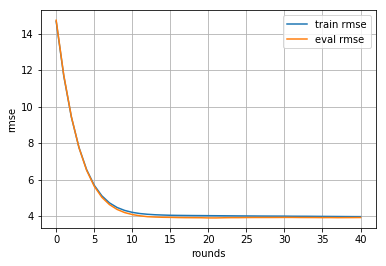

In [21]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

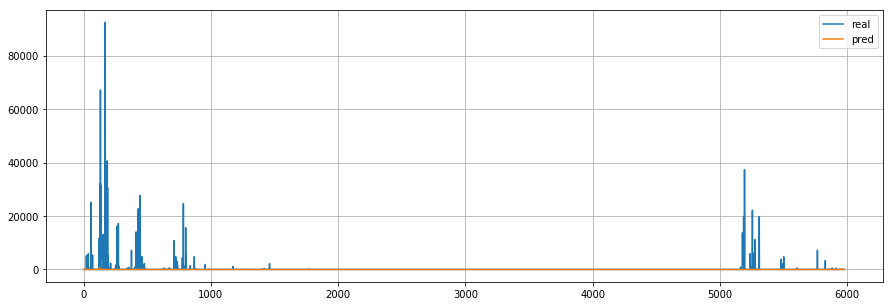

In [22]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['SalesSck'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

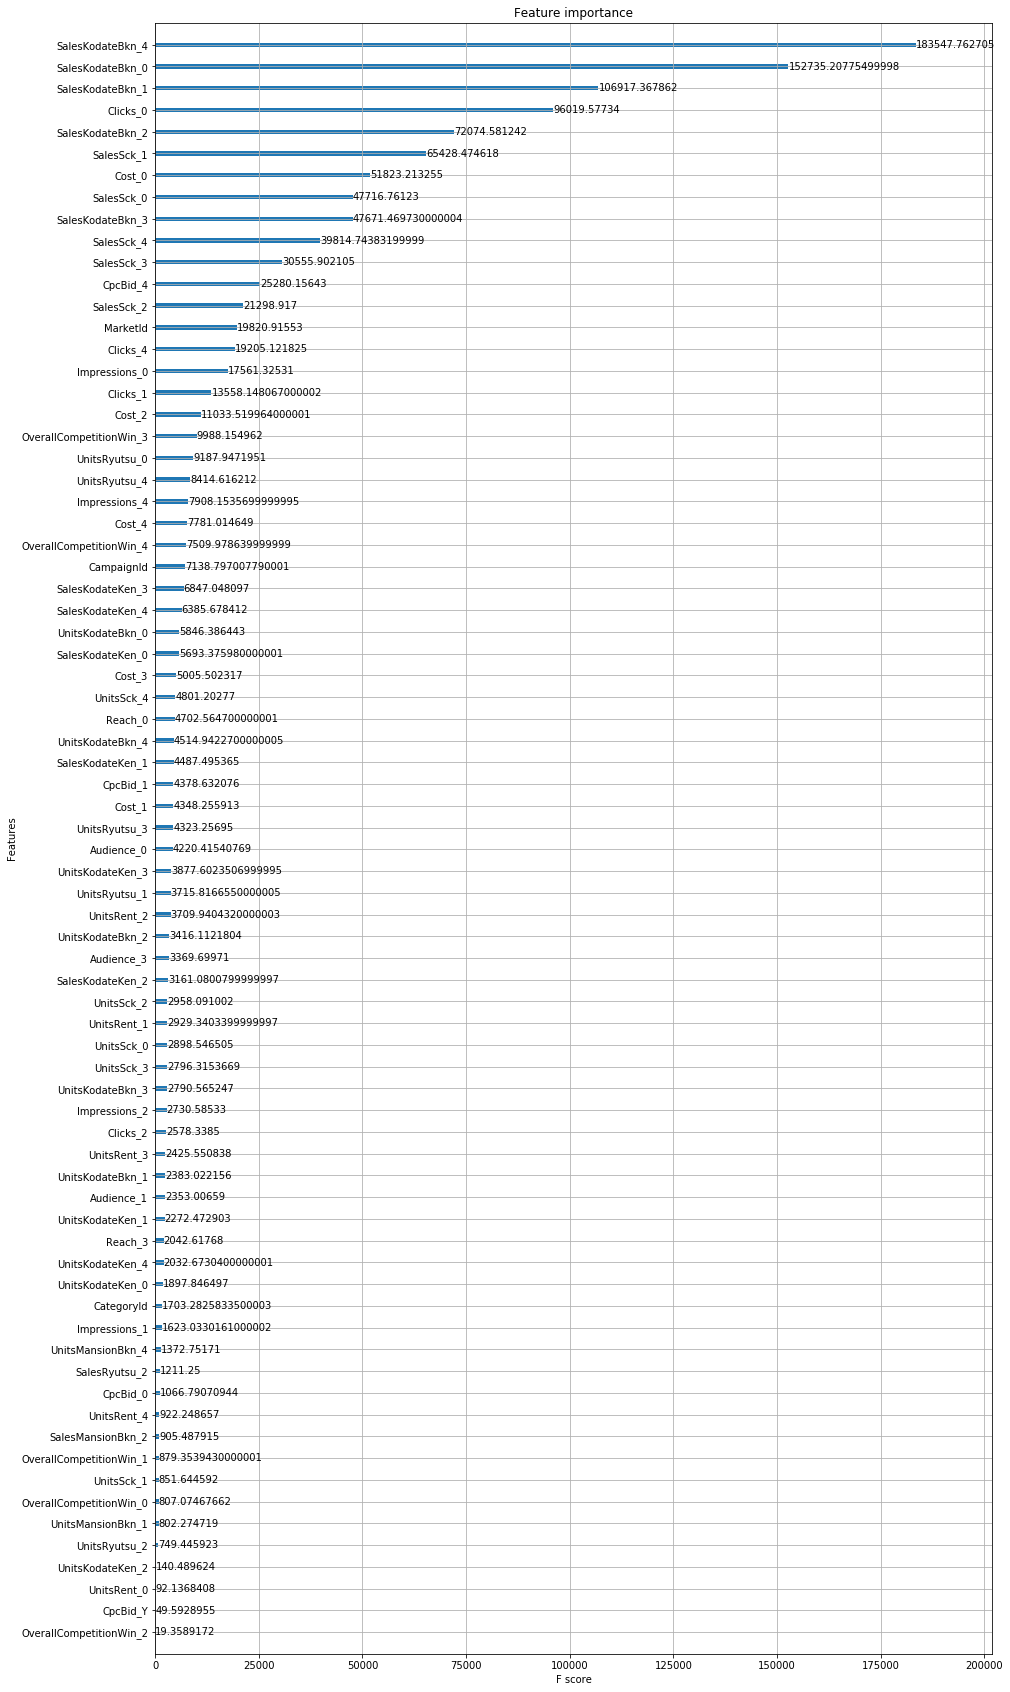

In [23]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='total_gain')
plt.show()

In [11]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['SalesKodateBkn_0',
 'SalesKodateBkn_1',
 'SalesKodateBkn_4',
 'Impressions_0',
 'SalesKodateBkn_3',
 'SalesSck_1',
 'SalesSck_4',
 'SalesKodateBkn_2',
 'SalesSck_0',
 'SalesRent_4',
 'SalesSck_3',
 'Audience_3',
 'Impressions_4',
 'Audience_1',
 'SalesRent_2',
 'SalesSck_2',
 'Clicks_4',
 'CpcBid_4',
 'UnitsMansionKen_4',
 'Clicks_0',
 'CpcBid_3',
 'Cost_0',
 'Impressions_1',
 'CampaignId',
 'UnitsRent_4',
 'Cost_1',
 'Cost_2',
 'CpcBid_2',
 'SalesKodateKen_2',
 'UnitsMansionKen_1',
 'SalesKodateKen_4',
 'UnitsRyutsu_4',
 'UnitsMansionKen_3',
 'Cost_4',
 'Cost_3',
 'Impressions_3',
 'UnitsRent_2',
 'UnitsRent_1',
 'UnitsRent_3',
 'Clicks_3',
 'SalesKodateKen_1',
 'UnitsMansionBkn_4',
 'Reach_4',
 'Reach_3',
 'SalesKodateKen_3',
 'SalesKodateKen_0',
 'Impressions_2',
 'OverallCompetitionWin_4',
 'Audience_2',
 'Audience_4',
 'Clicks_1',
 'UnitsKodateKen_4',
 'SalesRyutsu_4',
 'UnitsSck_4',
 'Reach_2',
 'Clicks_2',
 'OverallCompetitionWin_3',
 'UnitsMansionBkn_3',
 'UnitsRyutsu_3',
 'R